# Customer and Product Insights from Supermarket Receipt Data: Behavioral Analysis, Clustering and Classification

The aim of this data analysis is to answer a series of business-relevant questions that could help a supermarket improve its operations. To achieve this, we will analyze a dataset containing information about supermarket receipts.

# Dataset
Each row in the dataset represents an item purchased by a customer as part of a receipt. It includes detailed information about the transaction, such as pricing, discounts, product details, and customer-related data. Below is a table explaining each feature of the dataset:

| **Column name**       | **Description**                           |
|-----------------------|-------------------------------------------|
| **db_id**            | Database record id                        |
| **scontrino_id**     | The id of the receipt                     |
| **puntovendita_id**  | The supermarket id                        |
| **data**             | The date of the receipt                   |
| **cassa**            | The supermarket checkout id               |
| **cassiere**         | The employee id                           |
| **numero_scontrino** | The receipt number                      |
| **ora**              | The hour of the purchase                  |
| **tessera**         | The supermarket card id of the user       |
| **num_riga**        | The row number                            |
| **r_qta_pezzi**     | The number of a purchased product         |
| **r_peso**         | The weight of the product                 |
| **r_importo_lordo** | Gross price                               |
| **r_iva**          | Tax in %                                  |
| **r_sconto**       | Discount                                  |
| **r_tipo_riga**    | The row type                              |
| **cod_prod**       | The code of the product                   |
| **descr_prod**     | The product description                   |
| **cat_mer**        | Product category                          |
| **liv1**           | First level category id                   |
| **descr_liv1**     | First level category description          |
| **liv2**           | Second level category id                  |
| **descr_liv2**     | Second level category description         |
| **liv3**           | Third level category id                   |
| **descr_liv3**     | Third level category description          |
| **liv4**           | Fourth level category id                  |
| **descr_liv4**     | Fourth level category description         |
| **tipologia**      | Typology                                  |
| **descr_tipologia**| Description of the typology               |
| **cod_rep**        | Position product id                       |
| **descr_rep**      | Position product description              |

In [1]:
# Libraries used
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from datetime import timedelta
import holidays
from itertools import islice


In [2]:
# options
plt.style.use('dark_background') #dark mode

### Dataset exploration


In [3]:
# Load the dataset
pd.set_option('display.max_columns', None)
df = pd.read_csv('./datasets/AnonymizedFidelity.csv')

For our English-speaking audience, it would be helpful to translate the dataset column names into English. This will make the analysis more accessible and easier to follow.

In [4]:
# Dictionary mapping original column names to English translations
column_translation = { 
    "scontrino_id": "receipt_id",
    "puntovendita_id": "store_id",
    "data": "date",
    "cassa": "checkout_id",
    "cassiere": "cashier_id",
    "nummero_scontrino": "receipt_number",
    "ora": "time",
    "tessera": "fidelity",
    "t_flag": "card_flag",
    "num_riga": "row_number",
    "r_reparto_cdaplus": "department_code",
    "r_ean": "ean_code",
    "r_qta_pezzi": "quantity_pieces",
    "r_peso": "weight",
    "r_importo_lordo": "gross_amount",
    "r_imponibile": "taxable_amount",
    "r_iva": "tax_percentage",
    "r_sconto": "discount",
    "r_sconto_fide": "loyalty_discount", 
    "r_sconto_rip": "split_discount",
    "r_tipo_riga": "row_type",
    "cod_prod": "product_code",
    "descr_prod": "product_description",
    "cat_mer": "product_category",
    "cod_forn": "supplier_code",
    "descr_forn": "supplier_description",
    "liv1": "level1_id",
    "descr_liv1": "level1_description",
    "liv2": "level2_id",
    "descr_liv2": "level2_description",
    "liv3": "level3_id",
    "descr_liv3": "level3_description",
    "liv4": "level4_id",
    "descr_liv4": "level4_description",
    "tipologia": "typology",
    "descr_tipologia": "typology_description",
    "cod_rep": "position_code",
    "descr_rep": "position_description"
}

# Rename columns
df.rename(columns=column_translation, inplace=True)

#### Analytics on dataframe

In [5]:
products_purchased = df.shape[0]
print("\nDataset dimensions (rows, columns):", df.shape)


Dataset dimensions (rows, columns): (2331568, 39)


#### Analytics on supermarkets

In [6]:
num_supermarkets = df['store_id'].nunique()
print("Number of unique supermarkets:", num_supermarkets)

num_employee = df['cashier_id'].nunique()
print("\nNumber of unique employees:", num_employee)

employee_per_supermarket = df.groupby('store_id')['cashier_id'].nunique()
print("\nNumber of employees per supermarket:")
for supermarket, num_employee in employee_per_supermarket.items():
    print(f"Supermarket {supermarket}: {num_employee}")

Number of unique supermarkets: 3

Number of unique employees: 14

Number of employees per supermarket:
Supermarket 4542: 9
Supermarket 4653: 6
Supermarket 4659: 6


The total number of employees across all supermarkets exceeds the unique count of employees. This indicates that some employees worked in multiple supermarkets.

#### General analytics for each supermarket

In [7]:
# Group by store_id
store_group = df.groupby('store_id')

store_stats = store_group.agg(
    num_employees=('cashier_id', 'nunique'),
    first_date=('date', 'min'),
    last_date=('date', 'max'),
    first_time=('time', 'min'),
    last_time=('time', 'max'),
    products_sold=('quantity_pieces', 'sum'),
    gross_amount=('gross_amount', 'sum'),
    receipt_count=('receipt_id', 'nunique'),
    fidelity_clients=('fidelity', 'nunique'),
).sort_values('gross_amount', ascending=False)

store_stats

num_employees  first_date   last_date first_time last_time  \
store_id                                                               
4659                  6  2023-01-02  2023-12-31      08:13     21:33   
4653                  6  2023-01-02  2023-12-31      08:10     21:26   
4542                  9  2023-01-02  2023-12-31      08:49     21:36   

          products_sold  gross_amount  receipt_count  fidelity_clients  
store_id                                                                
4659            1041229    2211485.57          67359              3201  
4653            1011185    2021853.66          52326              2285  
4542             632799    1094364.03          34254              4350

The dataset spans one year of receipts. Two supermarkets typically open at 8:00 AM, while the others open at 8:30 AM. All supermarkets close at 10:00 PM. 

#### Analytics on receipts

In [8]:
num_receipts = df['receipt_id'].nunique()
print("Number of total receipts:", num_receipts)

average_products_per_receipt = products_purchased / num_receipts
print("Average number of distrinct products per receipt:", int(average_products_per_receipt))

Number of total receipts: 153939
Average number of distrinct products per receipt: 15


#### Analytics on clients

In [9]:
num_fidelity_clients = df['fidelity'].nunique()
print("Number of unique fidelity clients:", num_fidelity_clients)

average_receipt_per_client = num_receipts / num_fidelity_clients
print("Average number of receipts per client:", int(average_receipt_per_client))

Number of unique fidelity clients: 9376
Average number of receipts per client: 16


#### Analytics on products

In [10]:
print("\nTop 10 most purchased products:")
top_products = df['product_description'].value_counts().head(10)
print(top_products)


Top 10 most purchased products:
product_description
1090011       SHOPPERS TEST BIO 35X65 P.500     73899
1101882       PITITTU PANE SEM.RIM.GRANO DUR    39066
1028794       F.BANANE CHIQUITA EXTRA           12937
1012222       M.POLLO PETTO A FETTE             11495
1003475       GALBANI PROSC.COT.FETTAGOLOSA     11362
1021390       F.BANANE PREMIUM                  10153
1090346       GRANAROLO LATTE100%IT PS BR.1L     7982
1018440       ERIDANIA ZUCCHERO PACCO KG.1       7565
1021453       F.LATTUGA ROMANA                   7028
1021437       F.FINOCCHI                         6747
Name: count, dtype: int64


The product "SHOPPERS TEST BIO 35X65 P.500" should be removed from the analysis as it is not relevant to our objectives.

In [11]:
df = df[df['product_code'] != 1090011.0]

In [12]:
print("\nTop 10 most purchased products:")
top_products = df['product_description'].value_counts().head(10)
print(top_products)

average_price_per_item = df['gross_amount'].mean()
print("\nAverage price per item:", round(average_price_per_item, 2), "€")

# percentage of purches with discount
discounted_purchases = df[(df['discount'] > 0) | (df['loyalty_discount'] > 0) | (df['split_discount'] > 0)].shape[0]
percentage_discounted_purchases = (discounted_purchases / products_purchased) * 100
print("\nPercentage of purchases with discount:", round(percentage_discounted_purchases, 2), "%")


Top 10 most purchased products:
product_description
1101882       PITITTU PANE SEM.RIM.GRANO DUR    39066
1028794       F.BANANE CHIQUITA EXTRA           12937
1012222       M.POLLO PETTO A FETTE             11495
1003475       GALBANI PROSC.COT.FETTAGOLOSA     11362
1021390       F.BANANE PREMIUM                  10153
1090346       GRANAROLO LATTE100%IT PS BR.1L     7982
1018440       ERIDANIA ZUCCHERO PACCO KG.1       7565
1021453       F.LATTUGA ROMANA                   7028
1021437       F.FINOCCHI                         6747
1021446       F.ICEBERG                          6542
Name: count, dtype: int64

Average price per item: 2.35 €

Percentage of purchases with discount: 37.03 %


Counterintuitively, the majority of purchases occur without any discount applied.

In [13]:
# Group by receipt_id and calculate the total products per receipt
products_per_receipt = df.groupby('receipt_id')['quantity_pieces'].sum()

min_products_per_receipt = products_per_receipt.min()
max_products_per_receipt = products_per_receipt.max()
print("Minimum products per receipt:", min_products_per_receipt)
print("Maximum products per receipt:", max_products_per_receipt)

Minimum products per receipt: 1
Maximum products per receipt: 103672


There appears to be an outlier in the dataset: a single receipt with 528 products, which is highly improbable. Let's investigate further to identify any other inconsistencies in the data.

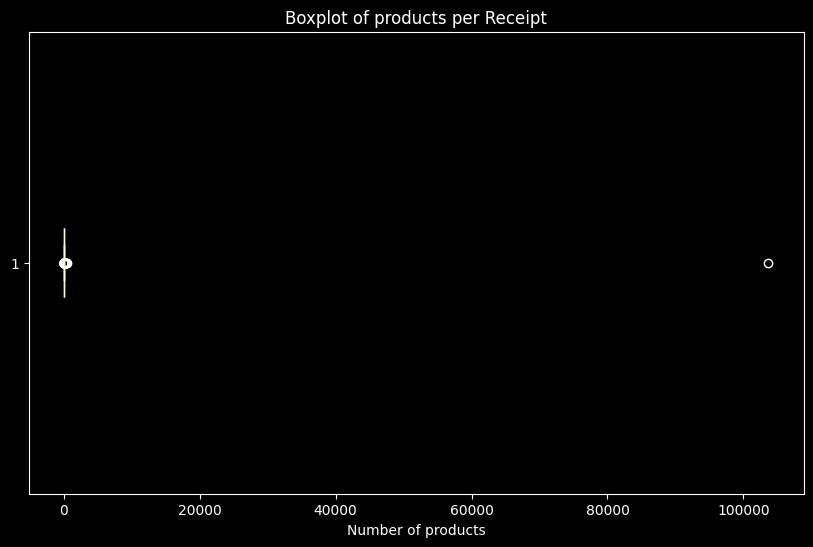

In [14]:
# Boxplot to detect outliers
plt.figure(figsize=(10, 6))
plt.boxplot(products_per_receipt, vert=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.title('Boxplot of products per Receipt')
plt.xlabel('Number of products')
plt.show()

In [15]:
# get the receipt with the maximum products
max_products_receipt = products_per_receipt.idxmax()
max_products_receipt_products = products_per_receipt[max_products_receipt]

print("\nReceipt ID with the maximum products:", max_products_receipt)


Receipt ID with the maximum products: 63473393


In [16]:
def parse_prod_name(name):
    """
    Extracts the product names from the product description.
    All products have the format "XXXXXXX       PRODUCT_NAME", where "XXXXXXX" is the product code.

    Parameters:
        name (str): The product description.

    Returns:
        tuple: A tuple containing the product code and the
        product name.
    """
    parts = name.split('       ')
    return int(parts[0]), parts[1]

def print_receipt_info(receipt_id):
    """
    Prints all information related to a given receipt ID.

    Parameters:
        receipt_id (int): The ID of the receipt to retrieve information for.
    """
    receipt_info = df[df['receipt_id'] == receipt_id]
    if receipt_info.empty:
        print(f"No information found for receipt ID: {receipt_id}")
        return
    
    print(f"\nReceipt ID: {receipt_id}")
    print(f"Number of products: {products_per_receipt[receipt_id]}")
    print(f"Total gross amount: {np.round(receipt_info['gross_amount'].sum(), 2)}€")
    print(f"Products purchased:")
    for index, row in receipt_info.iterrows():
        _, prod_name = parse_prod_name(row['product_description'])
        print(f"    -{prod_name} - Quantity: {row['quantity_pieces']} - Gross Amount: {row['gross_amount']}€")
    print(f"Date: {receipt_info['date'].unique()}")
    print(f"Time: {receipt_info['time'].unique()}")
    

In [17]:
print_receipt_info(max_products_receipt)


Receipt ID: 63473393
Number of products: 103672
Total gross amount: 78.04€
Products purchased:
    -FROSTA PLATESSA CROCCANTE G250 - Quantity: 1 - Gross Amount: 5.99€
    -KELLOGG SPECIAL K CLASS.GR.450 - Quantity: 1 - Gross Amount: 3.59€
    -F.MELE GOLD MELIN.75/80 D.O.P. - Quantity: 1 - Gross Amount: 1.71€
    -TEST MAIS DOLCE 3X160GR - Quantity: 1 - Gross Amount: 2.59€
    -JOLLY NETTARE PESCA ML.200x3   - Quantity: 1 - Gross Amount: 1.09€
    -JOLLY NETTARE MELA/BAN ML200X3 - Quantity: 1 - Gross Amount: 1.09€
    -JOLLY NETTARE MELA/BAN ML200X3 - Quantity: 1 - Gross Amount: 1.09€
    -F.PATATE SACCO KG.2.5 - Quantity: 103637 - Gross Amount: 0.0€
    -F.PATATE SACCO KG.2.5 - Quantity: 1 - Gross Amount: 2.69€
    -F.MELE GOLD MEL.4F GR650 D.O.P - Quantity: 1 - Gross Amount: 1.69€
    -M.POLLO BRACIOLA - Quantity: 1 - Gross Amount: 8.04€
    -LATTE SOLE UHT P/S LT1 - Quantity: 7 - Gross Amount: 6.23€
    -MULLER YOG.STRACCIAT. 2X125GR  - Quantity: 1 - Gross Amount: 0.85€
    -MULLER

<Axes: xlabel='quantity_pieces'>

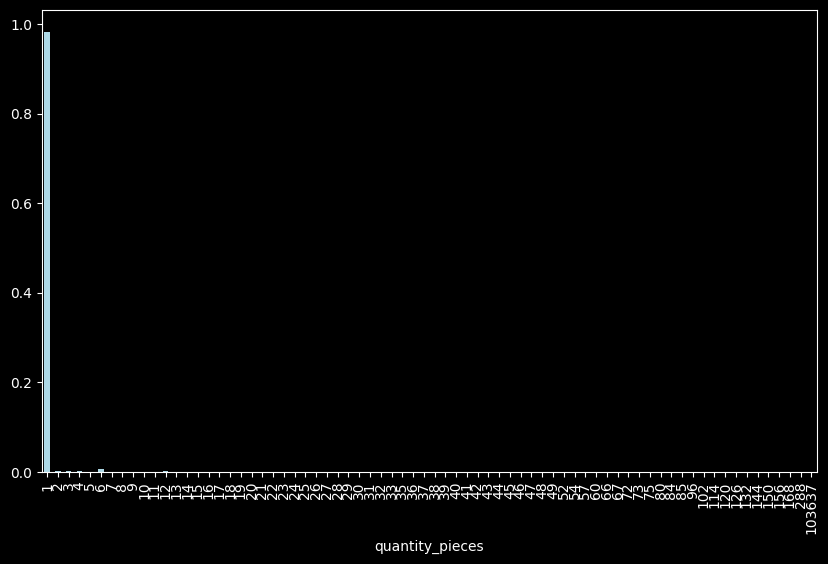

In [18]:
quantity_counts = df['quantity_pieces'].value_counts().sort_index()
# normalize the values
quantity_counts = quantity_counts / quantity_counts.sum()
quantity_counts.plot(kind='bar', figsize=(10, 6), color='lightblue')

The majority of purchases involve products with a quantity of 1. Let's analyze some receipts with "anomalous" quantities to better understand the data.

In [19]:
# Filter and aggregate
df_quantity_above_100 = (
    df[df['quantity_pieces'] > 100]
    .groupby('product_description')['quantity_pieces']
    .max()
    .reset_index(name='max_quantity')
    .sort_values(by='max_quantity', ascending=False)
)

# Display results
print(f"\nNumber of unique products with quantity above 100: {len(df_quantity_above_100)}")
print("\nProducts with quantity above 100:")
for _, row in df_quantity_above_100.iterrows():
    print(f"    - {row['product_description']} - Maximum quantity: {row['max_quantity']}")



Number of unique products with quantity above 100: 18

Products with quantity above 100:
    - 1037365       F.PATATE SACCO KG.2.5          - Maximum quantity: 103637
    - 1078018       SABRINELLA ACQUA FRIZZ. CL.50  - Maximum quantity: 288
    - 1017982       VITASNELLA ACQUA NATUR.CL.50   - Maximum quantity: 168
    - 1078017       SABRINELLA ACQUA NAT. CL.50    - Maximum quantity: 156
    - 1024514       SANTANNA ACQUA NATURALE LT.2   - Maximum quantity: 150
    - 1000946       MORETTI CL.66                  - Maximum quantity: 150
    - 1000796       LEVISSIMA ACQUA NATUR. CL. 50  - Maximum quantity: 144
    - 1000800       VERA ACQUA NATURALE CL. 50     - Maximum quantity: 144
    - 1024645       SANTANNA ACQUA NATURALE CL50(P - Maximum quantity: 144
    - 1000801       VERA ACQUA FRIZZANTE CL. 50    - Maximum quantity: 144
    - 1046978       PLASMON OMO GR.80X2 SPIG.      - Maximum quantity: 132
    - 1077929       SANTA MARIA ACQUA NAT.LT.2     - Maximum quantity: 126
    - 1

The dataset reveals that certain products are purchased in unusually high quantities, with some receipts showing over 100 units of the same item.

Several business and behavioral factors might explain these large purchase quantities:

1. **Bulk Purchases for Events or Institutions**  
   Some customers may be buying in bulk for:
   - Restaurants or bars (especially for water, beer, and soda)
   - Offices, schools, or gyms
   - Private events, parties, or catering services

2. **Promotional Offers and Discounts**  
   Promotions such as “Buy X, Get Y Free” or deep discounts on bulk quantities can incentivize customers to purchase unusually large volumes.

3. **Stockpiling Behavior**  
   Particularly for non-perishable or semi-perishable goods (e.g., bottled water, baby food, beer), customers might stock up during sales or ahead of holidays.


The majority of these products appear to be beverages and items for newborns.

In [20]:
# remove the product with quantity 103637
df = df[df['quantity_pieces'] != 103637]

### **Question 1**

**_Is there a correlation between the discount applied to a product and the quantity sold?_**

This question explores whether applying discounts leads to increased sales volume, which is a key metric for evaluating the effectiveness of promotions.
- A positive correlation might indicate that discounts successfully boost sales.
- A weak or no correlation might suggest that other factors (like product type, seasonality, or brand) play a larger role.
- A negative correlation could highlight ineffective promotions.

### **Question 2**

**_Which products show signs of untapped sales potential?_**

This type of analysis helps identify products that could benefit from increased visibility or promotional strategies, such as inclusion in loyalty point collection programs.

### **Question 3**

**_Can we identify distinct types of shopping days throughout the year?_**

Clustering shopping days based on customer and sales behavior helps uncover temporal patterns in purchasing dynamics. This can be valuable for:
- Understanding sales seasonality: spotting high-traffic days (e.g., holidays, weekends, promotion days).
- Operational planning: optimizing staff allocation, stock levels, and checkout resources during busy periods.
- Marketing strategy: identifying ideal days for promotions or campaigns based on historical success.
- Event anticipation_ detecting recurring peaks or slumps that aren't tied to fixed calendar holidays.

### **Question 4**

**_Can we build a model to classify whether a product purchase is likely to involve a discount?_**

It allows the business to better understand customer purchasing behavior, particularly in relation to price sensitivity. By identifying which products are most commonly bought with a discount, the supermarket can anticipate customer expectations and tailor its pricing strategies accordingly.

Moreover, such insights enable targeted promotions. Instead of applying blanket discounts, the retailer can focus promotional efforts on specific products or categories that are historically associated with discount-driven purchases. This approach ensures that marketing resources are allocated more efficiently, reaching the right products and customer segments. 

Finally, this type of model supports price optimization. Products that sell well without discounts can be excluded from routine markdowns, protecting profit margins.

# Answering question 1

**_Is there a correlation between the discount applied to a product and the quantity sold?_**

Understanding the Discount Percentages Applied by the Supermarket:

In [21]:
df_prices = df[['receipt_id', 'quantity_pieces', 'gross_amount', 'taxable_amount', 'tax_percentage', 'discount', 'loyalty_discount', 'split_discount', 'receipt_id', 'date', 'time', 'row_number', 'product_code', 'product_description']].copy()

In [22]:
# all unique value of discount
discount_values = df_prices['discount'].unique()
print("\nFirst 5 unique discount values:")
for value in discount_values[:5]:
    print(f"    - {value}€")


First 5 unique discount values:
    - 0.47€
    - 0.35€
    - 0.18€
    - 1.55€
    - 0.11€


The discount is not expressed as a percentage in the dataset. We can calculate the discount percentage using the gross price with the following formula:

$$
\text{total\_discount} = \text{discount} + \text{loyalty\_discount} + \text{split\_discount}
$$

<!-- $$
\text{list\_price} = \text{gross\_amount} + \text{total\_discount}
$$ -->

$$
\text{percentage\_discount} = \left( \frac{\text{total\_discount}}{\text{gross\_amount}} \right) \times 100
$$


In [23]:
# Calculate the total discount by summing the discount components
df_prices['total_discount'] = df_prices['discount'] + df_prices['loyalty_discount'] + df_prices['split_discount']
# remove the discount columns
df_prices.drop(columns=['discount', 'loyalty_discount', 'split_discount'], inplace=True)

Before calculating the percentage discount, let's first check if there are any products with a `gross_amount` of 0 to avoid division by zero errors.

In [24]:
free_products = df_prices[df_prices['gross_amount'] == 0]
print("\nNumber of free products:", free_products.shape[0])
free_products.head(10)


Number of free products: 7091


receipt_id  quantity_pieces  gross_amount  taxable_amount  \
372     52602483                1           0.0        0.696721   
486     52603584                1           0.0        3.172727   
526     52604180                1           0.0        1.721154   
655     52604765                1           0.0        1.144231   
803     52606273                1           0.0        2.942623   
1708    52612631                1           0.0        1.721154   
2042    62231689                1           0.0        1.872727   
2247    62233640                1           0.0        0.811475   
2345    62234514                1           0.0        1.136364   
2711    62236575                1           0.0        2.490385   

      tax_percentage  receipt_id        date   time  row_number  product_code  \
372               22    52602483  2023-03-26  10:40          21     1005970.0   
486               10    52603584  2023-03-26  10:54           1     1031566.0   
526                4    52604180  2023-03-26  11:03          49     1103187.0   
655                4    52604765  2023-03-26  11:11          65     1001228.0   
803               22    52606273  2023-03-26  11:36          15     1046233.0   
1708               4    52612631  2023-03-26  12:51          15     1103187.0   
2042              10    62231689  2023-10-01  09:56          22     1135516.0   
2247              22    62233640  2023-10-01  10:27           1     1133677.0   
2345              10    62234514  2023-10-01  10:23          65     1129824.0   
2711               4    62236575  2023-10-01  10:53          25     1102506.0   

                               product_description  total_discount  
372   1005970       ENERGADE ARANCIA ROSSA CL.50               0.0  
486   1031566       MISURA CORN.F.E.INT/MIEL.300 P             0.0  
526   1103187       F.COCCO GR.400                             0.0  
655   1001228       STAR PUMMARO' PASSATA ML.700               0.0  
803   1046233       COCA COLA LATT.MINI CAN CL15X6             0.0  
1708  1103187       F.COCCO GR.400                             0.0  
2042  1135516       PFITSCHER SPECK FORTEZZA 1/2               0.0  
2247  1133677       CHIOSCHI SPUMA CL.95                       0.0  
2345  1129824       CAMEO HIGH PR MOUSSE CIOC 100G             0.0  
2711  1102506       F.LIMONI RETE KG.1                         0.0

These products have a `gross_amount` of 0, not due to any applied discount. Such values are unusual and likely indicate data inconsistencies. Therefore, we will remove these entries from the dataset.

In [25]:
# Remove rows where 'gross_amount' is 0
df = df[df['gross_amount'] > 0]
df_prices = df_prices[df_prices['gross_amount'] > 0]

Let's check if there are products where the `total_discount` exceeds the `gross_amount`.

In [26]:
# Check if there are products where the total_discount exceeds the gross_amount
discount_exceeds_gross = df_prices[df_prices['total_discount'] > df_prices['gross_amount']]

# Display the number of such cases and a few examples
print("\nNumber of cases where total_discount exceeds gross_amount:", discount_exceeds_gross.shape[0])
discount_exceeds_gross.head(10)


Number of cases where total_discount exceeds gross_amount: 23339


receipt_id  quantity_pieces  gross_amount  taxable_amount  \
4      52597232                1          0.44        0.423077   
5      52597232                1          0.44        0.423077   
86     52599054                1          1.98        1.903846   
87     52599054                1          2.44        2.000000   
88     52599054                1          2.17        2.086538   
374    52602483                1          0.73        0.598361   
375    52602483                1          0.73        0.598361   
376    52602483                1          0.73        0.598361   
377    52602483                1          2.19        1.795082   
416    52603008                1          0.80        0.769231   

     tax_percentage  receipt_id        date   time  row_number  product_code  \
4                 4    52597232  2023-03-25  21:00          23     3000397.0   
5                 4    52597232  2023-03-25  21:00          25     3000397.0   
86                4    52599054  2023-03-26  08:54           2     1104783.0   
87               22    52599054  2023-03-26  08:54           4     1000152.0   
88                4    52599054  2023-03-26  08:54           6     1101882.0   
374              22    52602483  2023-03-26  10:40           5     1000946.0   
375              22    52602483  2023-03-26  10:40           7     1000946.0   
376              22    52602483  2023-03-26  10:40           9     1000946.0   
377              22    52602483  2023-03-26  10:40          11     1070682.0   
416               4    52603008  2023-03-26  10:46           1     1065859.0   

                              product_description  total_discount  
4    3000397       *TEST P.U.GRAM.TEST N/ANT G500            1.61  
5    3000397       *TEST P.U.GRAM.TEST N/ANT G500            1.61  
86   1104783       *.PATATE 3 KG                             3.02  
87   1000152       SCOTTEX CARTA IGIENICA X10 ROT            3.70  
88   1101882       PITITTU PANE SEM.RIM.GRANO DUR            3.28  
374  1000946       MORETTI CL.66                             0.92  
375  1000946       MORETTI CL.66                             0.92  
376  1000946       MORETTI CL.66                             0.92  
377  1070682       MAJOR PIATTO RIUT.PIANO PZ.35             2.20  
416  1065859        MB PANCARRE'16 FET.INTEG G315            0.84

One possible explanation for this case is that certain promotions might result in free products. For the purpose of our analysis, we will exclude these products.

In [27]:
# Remove rows from df and df_prices where receipt_id and row_number match those in discount_exceeds_gross
df = df[~df.index.isin(discount_exceeds_gross.index)]
df_prices = df_prices[~df_prices.index.isin(discount_exceeds_gross.index)]

In [28]:
# Calculate the discount percentage
df_prices['discount_percentage'] = ((df_prices['total_discount'] / df_prices['gross_amount']) * 100).astype(int)

df_prices.head(10)

receipt_id  quantity_pieces  gross_amount  taxable_amount  tax_percentage  \
0     52597232                1          0.78        0.750000               4   
1     52597232                1          2.64        2.163934              22   
2     52597232                1          1.41        1.281818              10   
3     52597232                1          1.41        1.281818              10   
6     52597232                1          0.88        0.846154               4   
7     52597232                1          4.58        4.163636              10   
8     52597232                1         14.07       12.790909              10   
9     52597232                1          8.74        7.945455              10   
10    52597232                1          0.99        0.900000              10   
11    52597232                1          0.79        0.759615               4   

    receipt_id        date   time  row_number  product_code  \
0     52597232  2023-03-25  21:00           1     1004624.0   
1     52597232  2023-03-25  21:00          17     1090781.0   
2     52597232  2023-03-25  21:00          19     3000305.0   
3     52597232  2023-03-25  21:00          21     3000305.0   
6     52597232  2023-03-25  21:00           3     3000226.0   
7     52597232  2023-03-25  21:00           5     1012141.0   
8     52597232  2023-03-25  21:00           7     1012128.0   
9     52597232  2023-03-25  21:00           9     1012222.0   
10    52597232  2023-03-25  21:00          11     3500912.0   
11    52597232  2023-03-25  21:00          13     1000862.0   

                             product_description  total_discount  \
0   1004624       ZAPPALA LATTE UHT P/S LT.1                0.57   
1   1090781       CUKI TEGLIA EXTRA S97 8POR.X2             0.70   
2   3000305       TEST SFOGLIA RETT.S/O.PAL230G             0.36   
3   3000305       TEST SFOGLIA RETT.S/O.PAL230G             0.36   
6   3000226       TEST PASSATA EX.FINE MAR.ML700            0.22   
7   1012141       M.BOVINO AD TRITATO II TAGLIO             1.20   
8   1012128       M.BOVINO AD OSSO PIATTO                   3.70   
9   1012222       M.POLLO PETTO A FETTE                     2.30   
10  3500912       TEST SALSA CIL.SIC.FF GR 350              0.63   
11  1000862       SUPERCIRIO GR. 140                        0.20   

    discount_percentage  
0                    73  
1                    26  
2                    25  
3                    25  
6                    25  
7                    26  
8                    26  
9                    26  
10                   63  
11                   25

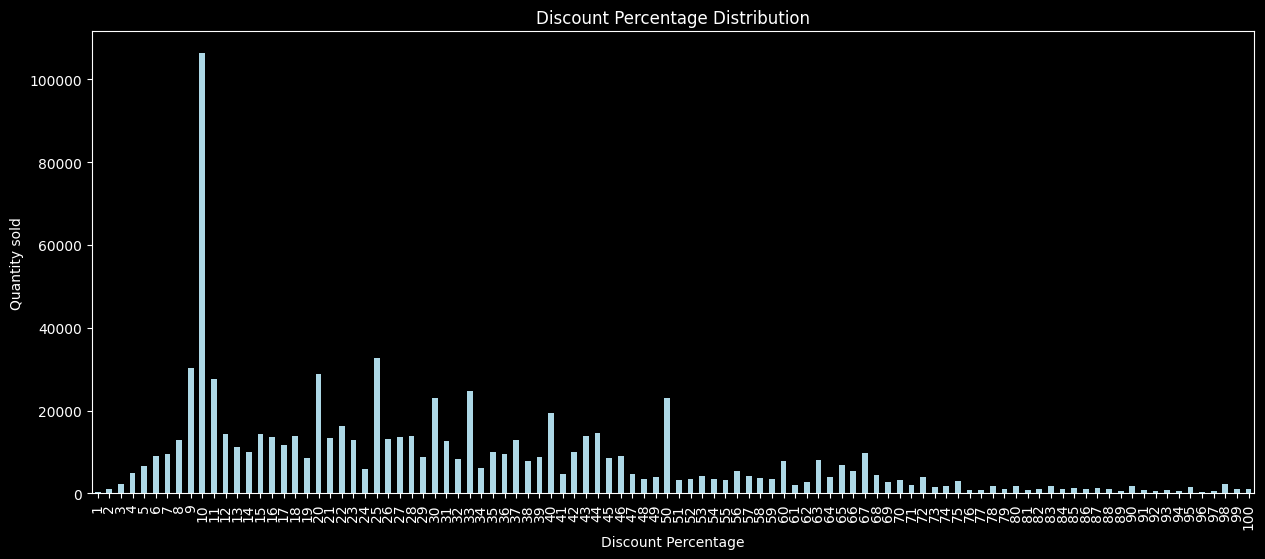

In [29]:
# all unique value of perc_discount
perc_discount_values = df_prices['discount_percentage'].value_counts()

# ignore the values with 0 discount
perc_discount_values = perc_discount_values[perc_discount_values.index > 0]

# sort the values
perc_discount_values = perc_discount_values.sort_index()

# bar plot
plt.figure(figsize=(15, 6))
perc_discount_values.plot(kind='bar', color='lightblue')
plt.title('Discount Percentage Distribution')
plt.xlabel('Discount Percentage')
plt.ylabel('Quantity sold')
plt.show()

At first glance, seeing discount percentages as high as 99% or 100% might seem unusual in a supermarket setting. However, there are several reasonable explanations behind such extreme values that make sense when we consider the operational and promotional strategies common in large-scale retail.

Supermarkets regularly deal with perishable goods and fast-moving consumer items. When products approach their expiry dates, or when a new version or brand is taking over shelf space, the older stock is often marked down drastically. A yogurt that expires tomorrow, for instance, might be sold for just a few cents to avoid throwing it away. In such cases, a product originally priced at €1.50 might sell for €0.01, technically representing a 99% discount.

Supermarkets frequently run aggressive promotions to attract foot traffic or to promote specific brands. These can include:
- Buy one, get one free offers
- Loyalty card rewards

When stacked, these discounts can reduce the final price dramatically compared to the original shelf price, sometimes approaching or effectively becoming 99%.

Here is a function to analize the products with a specific discunt percentage!

In [30]:
def top_n_sold_products_with_discount(discount_percentage, n=5):
    """
    Print the product names with a specific discount value.

    Parameters:
        discount_percentage (float): The discount value to filter by.
        number_of_products (int): The number of top products to display.
    """
    products = df_prices[df_prices['discount_percentage'] == discount_percentage]['product_description'].value_counts()
    # sort the values
    products = products.sort_values(ascending=False)
    print(f"\nProducts with {discount_percentage}% discount:")
    for product, count in products.head(n).items():
        print(f"    - {parse_prod_name(product)[1]} (Count: {count})")

In [32]:
top_n_sold_products_with_discount(100)
top_n_sold_products_with_discount(99)
top_n_sold_products_with_discount(98)
top_n_sold_products_with_discount(97)
top_n_sold_products_with_discount(96)
top_n_sold_products_with_discount(95)
top_n_sold_products_with_discount(94)


Products with 100% discount:
    - AZ DENT.PRO.CARIE GEL ML.75+10 (Count: 109)
    - AZ DENT.PROT.FAM. 75+10 ML (P) (Count: 94)
    - AZ DENT. COMPLETE PROTEZ.ML.65 (Count: 92)
    - AZ DENT.TARTAR CONTR. ML75+10  (Count: 91)
    - AZ DENT. COMPLETE FRESH  ML.65 (Count: 67)

Products with 99% discount:
    - CASA M.MORTADELLINA GR.150     (Count: 61)
    - PARMALAT ZYMIL 0,1% BOTT.LT.1  (Count: 44)
    - TEST TRECC YOG NO PALMA GR 252 (Count: 38)
    - OROGEL MINESTRONE LEGG. GR.750 (Count: 36)
    - NEGRONI PR.COTTO STELLA GR 110 (Count: 31)

Products with 98% discount:
    - LIFEBUOY SAP.LIQ.RIC.IGIEN.443 (Count: 1336)
    - PARMAREGGIO BURRO GR.100       (Count: 85)
    - FRUTTOLO Y.& SMART FRAG GR120# (Count: 66)
    - NEGRONI SALAME NEGRONETTO GR75 (Count: 44)
    - NEGRONI SALAME NEGRONETTO 75GR (Count: 31)

Products with 97% discount:
    - AIA WURSTEL WUDY FORMAGG.150GR (Count: 19)
    - GALBANI SL MOZZAR 3X100GR  FL  (Count: 16)
    - PITITTU PANE SEM.RIM.GRANO DUR (Count: 10

It's time to answer the first question: **Is there a correlation between the discount applied to a product and the quantity sold?**

To answer the question we start by finding for each product the quantity sold with and without a discount.

In [33]:
# Create a boolean column to indicate whether the item was sold with a discount
df_prices['with_discount'] = df_prices['total_discount'] > 0

# Group by product_code and with_discount, and sum quantity_pieces
discount_analysis = (
    df_prices
    .groupby(['product_code', 'with_discount'], as_index=False)['quantity_pieces']
    .sum()
    .rename(columns={'quantity_pieces': 'total_quantity'})
)

display(discount_analysis)

product_code  with_discount  total_quantity
0         1000013.0          False             242
1         1000013.0           True              36
2         1000028.0          False             132
3         1000028.0           True             257
4         1000040.0          False              83
...             ...            ...             ...
34613     5200158.0          False               8
34614     5200276.0          False              63
34615     5200276.0           True              12
34616    10013191.0          False              54
34617    10013191.0           True              11

[34618 rows x 3 columns]

In [34]:
pivot_discount_analysis = discount_analysis.pivot(index='product_code', columns='with_discount', values='total_quantity')
pivot_discount_analysis.columns = ['quantity_without_discount', 'quantity_with_discount']
pivot_discount_analysis = pivot_discount_analysis.fillna(0)  # handle missing values

display(pivot_discount_analysis.head(20))


quantity_without_discount  quantity_with_discount
product_code                                                   
1000013.0                         242.0                    36.0
1000028.0                         132.0                   257.0
1000040.0                          83.0                    24.0
1000062.0                          36.0                    71.0
1000102.0                          72.0                    38.0
1000103.0                         103.0                    46.0
1000106.0                         206.0                    25.0
1000107.0                         355.0                   129.0
1000109.0                         130.0                    13.0
1000116.0                          92.0                    15.0
1000117.0                          12.0                     3.0
1000120.0                          23.0                     6.0
1000121.0                         104.0                    17.0
1000125.0                           2.0                     0.0
1000135.0                           1.0                     0.0
1000136.0                          87.0                    22.0
1000137.0                        1459.0                   315.0
1000138.0                        1666.0                   353.0
1000139.0                         398.0                   105.0
1000152.0                         287.0                   422.0

It is convenient to use a dispersion plot to visualize the relationship between two variables, such as the quantity of products sold with and without discounts. Dispersion plots help identify patterns, trends, and potential correlations in the data. For example, we can use a log-log scale to better observe the distribution of quantities across a wide range of values. Additionally, overlaying a diagonal reference line (y = x) can help compare the quantities directly:
- Each product above the diagonal sells better when it is on sale.  
- Each product below the diagonal sells better when it is not on sale.

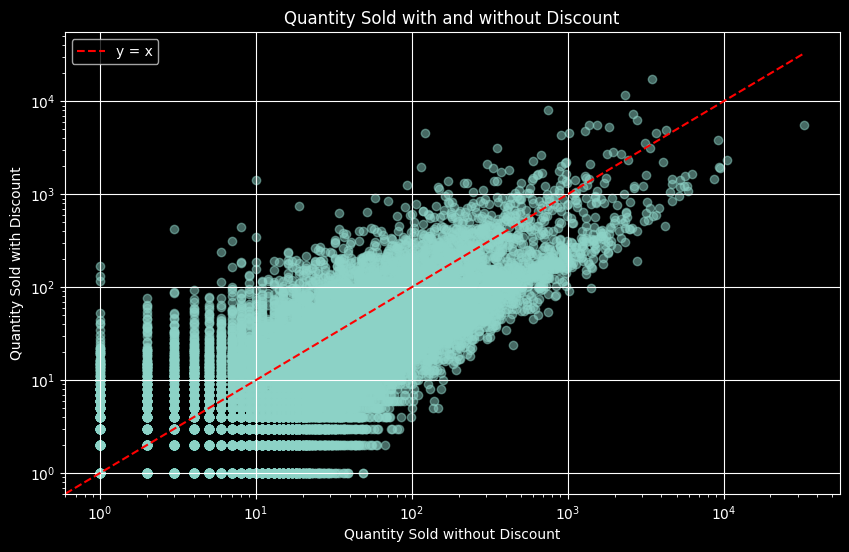

In [35]:
plt.figure(figsize=(10, 6))

plt.scatter(
    pivot_discount_analysis['quantity_without_discount'], 
    pivot_discount_analysis['quantity_with_discount'], 
    alpha=0.5
)

# Diagonal line
min_val = min(pivot_discount_analysis[['quantity_without_discount', 'quantity_with_discount']].min())
max_val = max(pivot_discount_analysis[['quantity_without_discount', 'quantity_with_discount']].max())
diagonal = np.linspace(min_val, max_val, 100)
plt.plot(diagonal, diagonal, 'r--', label='y = x')  # Red dashed line

# Labels and scales
plt.title('Quantity Sold with and without Discount')
plt.xlabel('Quantity Sold without Discount')
plt.ylabel('Quantity Sold with Discount')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

The products below the red line are those that sell better without a discount (`quantity_without_discount > quantity_with_discount`), while the products above the red line sell better with a discount (`quantity_with_discount > quantity_without_discount`).

To measure the effectiveness of applying or not applying a discount to a product, we evaluate the difference in quantities sold with and without a discount. For products that sell better with a discount, the best-case scenario is when `quantity_without_discount` is close to `0`, while the worst-case scenario is when `quantity_without_discount` is similar to `quantity_with_discount` (i.e., the product is near the red line).

We can use the following formula to calculate the effectiveness:

$$
\text{Effectiveness} = \frac{\text{quantity\_with\_discount} - \text{quantity\_without\_discount}}{\text{quantity\_with\_discount} + \text{quantity\_without\_discount} + 1}
$$

This metric will be maximal when `quantity_with_discount` approaches `0` and minimal when `quantity_with_discount` is similar to `quantity_without_discount`. We add $+1$ in the denominator to penalize products sold in small quantities. For example, if `quantity_with_discount` = 1 and `quantity_without_discount` = 0, the effectiveness is 1 without $+1$ and 0.5 with this adjustment.

For products that sell better without a discount we use:
$$
\text{Effectiveness} = \frac{\text{quantity\_without\_discount} - \text{quantity\_with\_discount}}{\text{quantity\_with\_discount} + \text{quantity\_without\_discount} + 1}
$$

In [36]:
def effectiveness(x, y):
    if x < y:
        raise ValueError("x must be greater than or equal to y")
    return (x - y) / (x + y + 1)

In [37]:
# Filter products that sell better with discounts
products_better_with_discount = pivot_discount_analysis[
    pivot_discount_analysis['quantity_with_discount'] > pivot_discount_analysis['quantity_without_discount']
].copy()
products_better_with_discount['effectiveness'] = products_better_with_discount.apply(
    lambda row: effectiveness(row['quantity_with_discount'], row['quantity_without_discount']), axis=1
)
products_better_with_discount = products_better_with_discount.sort_values('effectiveness', ascending=False)

# Filter products that sell better without discounts
products_better_without_discount = pivot_discount_analysis[
    pivot_discount_analysis['quantity_without_discount'] > pivot_discount_analysis['quantity_with_discount']
].copy()
products_better_without_discount['effectiveness'] = products_better_without_discount.apply(
    lambda row: effectiveness(row['quantity_without_discount'], row['quantity_with_discount']), axis=1
)
products_better_without_discount = products_better_without_discount.sort_values('effectiveness', ascending=False)

def get_product_name(product_code):
    """
    Get the product name from the product code.

    Parameters:
        product_code (int): The product code.

    Returns:
        str: The product name.
    """
    return df_prices[df_prices['product_code'] == product_code]['product_description'].unique()[0]

# Add product names to the DataFrame
products_better_with_discount['product_name'] = products_better_with_discount.index.map(get_product_name)
products_better_without_discount['product_name'] = products_better_without_discount.index.map(get_product_name)

print("Products that sell better with discounts:")
display(products_better_with_discount)

print("\nProducts that sell better without discounts:")
display(products_better_without_discount)

Products that sell better with discounts:


quantity_without_discount  quantity_with_discount  \
product_code                                                      
1110386.0                           0.0                   306.0   
3502047.0                           0.0                   102.0   
1100180.0                           0.0                    84.0   
1046738.0                          10.0                  1418.0   
1042851.0                           0.0                    65.0   
...                                 ...                     ...   
3000541.0                         231.0                   233.0   
3000274.0                         734.0                   740.0   
1082573.0                         557.0                   561.0   
1001999.0                         165.0                   166.0   
1026725.0                         221.0                   222.0   

              effectiveness                                  product_name  
product_code                                                               
1110386.0          0.996743  1110386       LIBRI DI TESTO                  
3502047.0          0.990291  3502047       TEST CECI GR.380                
1100180.0          0.988235  1100180       F.MELE GOLDEN MELINDA KG2.3     
1046738.0          0.985304  1046738       LIFEBUOY SAP.LIQ.RIC.IGIEN.443  
1042851.0          0.984848  1042851       PAMPERS SALV.SOLE/LUNA PZ.40    
...                     ...                                           ...  
3000541.0          0.004301  3000541       TEST CROSTINI CROCC. NO PAL280  
3000274.0          0.004068  3000274       TEST FARINA TIPO 00 1KG         
1082573.0          0.003575  1082573       FANTA PET ML.900 (P)            
1001999.0          0.003012  1001999       BARILLA 175 P/U FETTUCC 250GR   
1026725.0          0.002252  1026725       CAMEO FR MUU MUU GO 80GR        

[5724 rows x 4 columns]


Products that sell better without discounts:


quantity_without_discount  quantity_with_discount  \
product_code                                                      
1082153.0                         261.0                     0.0   
1024823.0                         195.0                     0.0   
1117985.0                         122.0                     0.0   
1085542.0                          67.0                     0.0   
1091037.0                          41.0                     0.0   
...                                 ...                     ...   
1084703.0                         135.0                   134.0   
1016041.0                         136.0                   135.0   
1047206.0                         138.0                   137.0   
1023573.0                         150.0                   149.0   
1011258.0                         368.0                   367.0   

              effectiveness                                  product_name  
product_code                                                               
1082153.0          0.996183  1082153       SACCHETTO BIO PER ALIMENTI      
1024823.0          0.994898  1024823       *.VINO IN PROMOZIONE            
1117985.0          0.991870  1117985       *VIROSAC SALVIETTE DET.MANI X1  
1085542.0          0.985294  1085542       ETICHETTA PR.50% ROTOLO PZ.300  
1091037.0          0.976190  1091037       CERES STRONG ALE LATT. CL.50    
...                     ...                                           ...  
1084703.0          0.003704  1084703       ZUEGG SKIP.PERA S/Z ML.200X3    
1016041.0          0.003676  1016041       ATI TE NERO 25 FILTRI CLASSICO  
1047206.0          0.003623  1047206       S.BENEDETTO SUCC.0 FR/ROSSI90   
1023573.0          0.003333  1023573       FRASSELLO VINO BRIK ROSATO LT1  
1011258.0          0.001359  1011258       SCOTTEX TOVAGLIOLI 1V X250      

[12917 rows x 4 columns]

To refine the analysis, we should consider the following adjustments:

1. **Products That Sell Better with Discounts**  
    Include only products where `quantity_without_discount > 0`. This ensures that we exclude products that are always sold with a discount, as their sales behavior cannot be compared meaningfully.

2. **Products That Sell Better without Discounts**  
    Similarly, include only products where `quantity_with_discount > 0`. For instance, the product `'082153 SACCHETTO BIO PER ALIMENTI'` is always sold without a discount, likely because it is never discounted, no body woud ever discount a plastic bag!. Including such products in the analysis would skew the results.

These refinements will provide a more accurate representation of the impact of discounts on product sales.

In [38]:
products_better_with_discount = products_better_with_discount[products_better_with_discount['quantity_without_discount'] > 0]
products_better_without_discount = products_better_without_discount[products_better_without_discount['quantity_with_discount'] > 0]

print("Top 10 Products that sell better with discounts:")
display(products_better_with_discount.head(10))

print("\nTop 10 Products that sell better without discounts:")
display(products_better_without_discount.head(10))

Top 10 Products that sell better with discounts:


quantity_without_discount  quantity_with_discount  \
product_code                                                      
1046738.0                          10.0                  1418.0   
1039941.0                           3.0                   427.0   
1039943.0                           1.0                   171.0   
1084673.0                           1.0                   131.0   
1100177.0                           1.0                   116.0   
1023671.0                           8.0                   441.0   
1039944.0                           7.0                   314.0   
1016951.0                          19.0                   744.0   
1008775.0                         121.0                  4558.0   
1028792.0                           6.0                   240.0   

              effectiveness                                  product_name  
product_code                                                               
1046738.0          0.985304  1046738       LIFEBUOY SAP.LIQ.RIC.IGIEN.443  
1039941.0          0.983759  1039941       ELIOS BICCHIERE ROSSO PZ.2x50   
1039943.0          0.982659  1039943       *LIOS PIATTO FONDO ROSSO X20(P  
1084673.0          0.977444  1084673       AVERNA AMARO CL.70 GIFT PACK    
1100177.0          0.974576  1100177       F.MELE STARK MELASI KG1.5       
1023671.0          0.962222  1023671       GRANAROLO MOZZARELLA GR100X4    
1039944.0          0.953416  1039944       ELIOS PIATTO PIANO ROSSO PZ.20  
1016951.0          0.948953  1016951       BECK'S BIRRA BOTTIGLIA CL.50    
1008775.0          0.948077  1008775        GRANAR.MOZZARELLA GR.100X3     
1028792.0          0.947368  1028792       NATURIZIA FUNGH CHAMP AFF.150G


Top 10 Products that sell better without discounts:


quantity_without_discount  quantity_with_discount  \
product_code                                                      
1008198.0                          49.0                     1.0   
1127048.0                          49.0                     1.0   
1081244.0                          67.0                     2.0   
1038547.0                         147.0                     5.0   
1109796.0                          39.0                     1.0   
1120450.0                          39.0                     1.0   
1069364.0                          38.0                     1.0   
1023561.0                          37.0                     1.0   
1001581.0                         136.0                     5.0   
1017891.0                          36.0                     1.0   

              effectiveness                                  product_name  
product_code                                                               
1008198.0          0.941176  1008198       *ASTRO AZZURRO BIRRA CL.66      
1127048.0          0.941176  1127048       F.MENTA IN VASCHETTA            
1081244.0          0.928571  1081244       HEINEKEN CL.33                  
1038547.0          0.928105  1038547       SHOPPERS CRAI EXTRA BIO 32X60   
1109796.0          0.926829  1109796       L'ANGEL.BARRET.PROT.CACAO GR40  
1120450.0          0.926829  1120450       *ERRERO COLL.ROCHER T3X20 G175  
1069364.0          0.925000  1069364       PLASMON FR YOG.BANANA 2X100GR   
1023561.0          0.923077  1023561       PAN FARINA MAIS KG.1            
1001581.0          0.922535  1001581       *PALMERA TONNO O.O. GR.80X3     
1017891.0          0.921053  1017891       FELCE ACQUA STIRO LT.1

Now that we know the product that sell better on sales let's see what products sell better when the discount is higher.

Let's add to our dataframe another columns, the correlation between the quantity sold and the discount.

In [39]:
def correlation_quantity_sold_and_discount(product_code):
    """
    Calculate the correlation between quantity sold and discount for a specific product.
    It plots the correlation between the quantity sold and the discount for a specific product.
    """
    product_data = df_prices[df_prices['product_code'] == product_code]
    product_data = product_data.groupby('total_discount')['quantity_pieces'].sum().reset_index()
    product_data['total_discount'] = product_data['total_discount'].astype(float)
    product_data = product_data.sort_values('total_discount')
    product_data = product_data[product_data['quantity_pieces'] > 0]
    product_data.reset_index(drop=True, inplace=True)

    # Check for sufficient variation
    if len(product_data) < 2 or product_data['total_discount'].std() == 0 or product_data['quantity_pieces'].std() == 0:
        # Not enough variation in the data to calculate correlation
        return None
    return product_data['quantity_pieces'].corr(product_data['total_discount'])

In [40]:
products_better_with_discount['correlation'] = products_better_with_discount.index.map(correlation_quantity_sold_and_discount)

In [41]:
# remove the products with correlation None
products_better_with_discount = products_better_with_discount[products_better_with_discount['correlation'].notna()]
# sort the values by correlation and effectiveness
products_better_with_discount = products_better_with_discount.sort_values(['correlation', 'quantity_with_discount', 'effectiveness'], ascending=[False, False, False])
display(products_better_with_discount.head(10))

quantity_without_discount  quantity_with_discount  \
product_code                                                      
1030300.0                          16.0                    34.0   
1078506.0                           4.0                    23.0   
1105657.0                           6.0                    22.0   
1046932.0                          11.0                    22.0   
3501616.0                           5.0                    18.0   
1091407.0                           5.0                    18.0   
1099611.0                          13.0                    18.0   
1107739.0                           2.0                    16.0   
1046457.0                           7.0                    16.0   
1132893.0                           9.0                    16.0   

              effectiveness                                  product_name  \
product_code                                                                
1030300.0          0.352941  1030300       MULLER Y.SETA AGR/MA 125X2G      
1078506.0          0.678571  1078506       *MONSTER VR46 LATT.CL.50         
1105657.0          0.551724  1105657       *IGUORI LING.GRAGNANO IGP G500   
1046932.0          0.323529  1046932       *ENTADENT DENT.WH.S BICARB75(P   
3501616.0          0.541667  3501616       TEST SALS.POL.TAC.SUINO GR.400   
1091407.0          0.541667  1091407       *AIRY PLATINUM LEMON 65 CAPS     
1099611.0          0.156250  1099611       PERUG.CREME DESS.CIO.BIAN.70X4   
1107739.0          0.736842  1107739       *DOLFIN UOVO EMOJI FOND.GR.220   
1046457.0          0.375000  1046457       CUKI VASSOIO ALLUMINIO V35       
1132893.0          0.269231  1132893       PARMALAT YO ZYMIL BEN BIA125X2   

              correlation  
product_code               
1030300.0             1.0  
1078506.0             1.0  
1105657.0             1.0  
1046932.0             1.0  
3501616.0             1.0  
1091407.0             1.0  
1099611.0             1.0  
1107739.0             1.0  
1046457.0             1.0  
1132893.0             1.0

In [42]:
def top_n_product_codes_with_discount(n = 10, min_correlation = -1, max_correlation = 1):
    df_tmp = products_better_with_discount[
        (products_better_with_discount['correlation'] >= min_correlation) &
        (products_better_with_discount['correlation'] <= max_correlation)
    ]
    top_product_codes = []
    # get the products codes
    n = min(n, len(df_tmp))
    for i in range(n):
        code, name = parse_prod_name(df_tmp.iloc[i]['product_name'])
        top_product_codes.append(code)
        
    return top_product_codes

def plot_top_products_on_sales(product_codes):
    """
    Plot the sales of the top products with and without discounts in a grid layout.
    """
    num_products = len(product_codes)
    num_cols = 2
    num_rows = (num_products + 1) // num_cols  # Calculate rows dynamically
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, product_code in enumerate(product_codes):
        product_data = df_prices[df_prices['product_code'] == product_code]
        product_data = product_data.groupby('total_discount')['quantity_pieces'].sum().reset_index()
        product_data = product_data.sort_values('total_discount')
        correlation = product_data['quantity_pieces'].corr(product_data['total_discount'])
        ax = axes[i]
        ax.scatter(product_data['total_discount'], product_data['quantity_pieces'], label=f"Product {int(product_code)}", alpha=0.7)
        ax.set_title(f"Product: {get_product_name(product_code)} | Correlation: {correlation:.2f}")
        ax.set_xlabel('Total discount (€)')
        ax.set_ylabel('Quantity Sold')
        ax.legend()

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

Finally it's really the time to check which products sell better on sales:

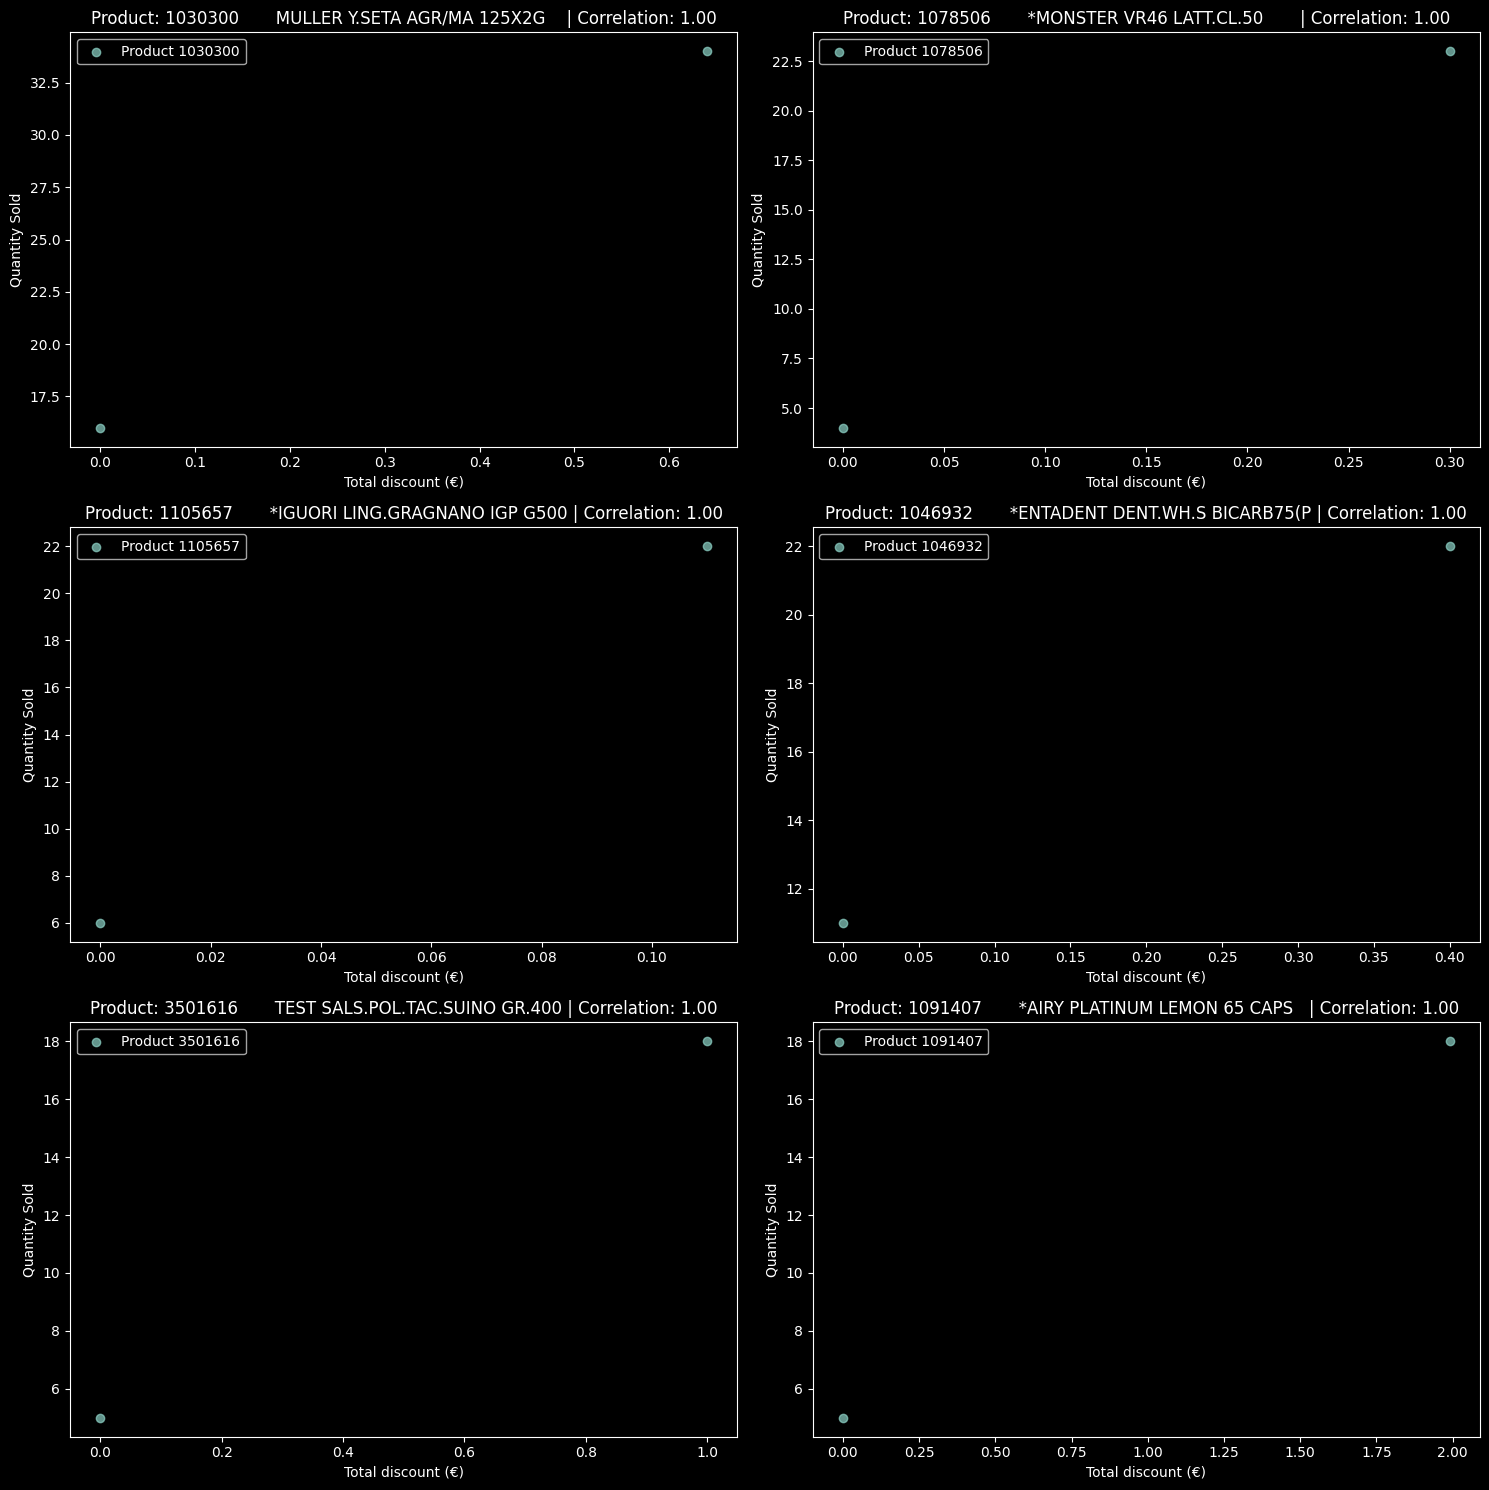

In [43]:
n = 6
plot_top_products_on_sales(top_n_product_codes_with_discount(n = n, max_correlation=1))

Selecting products with very high correlation is not particularly insightful. As observed, the plots often show only two points: one where the product is sold with a discount and another where it is not sold at all without a discount. This lack of variation limits the usefulness of such correlations in understanding sales behavior.

Now, we establish a maximum correlation threshold.

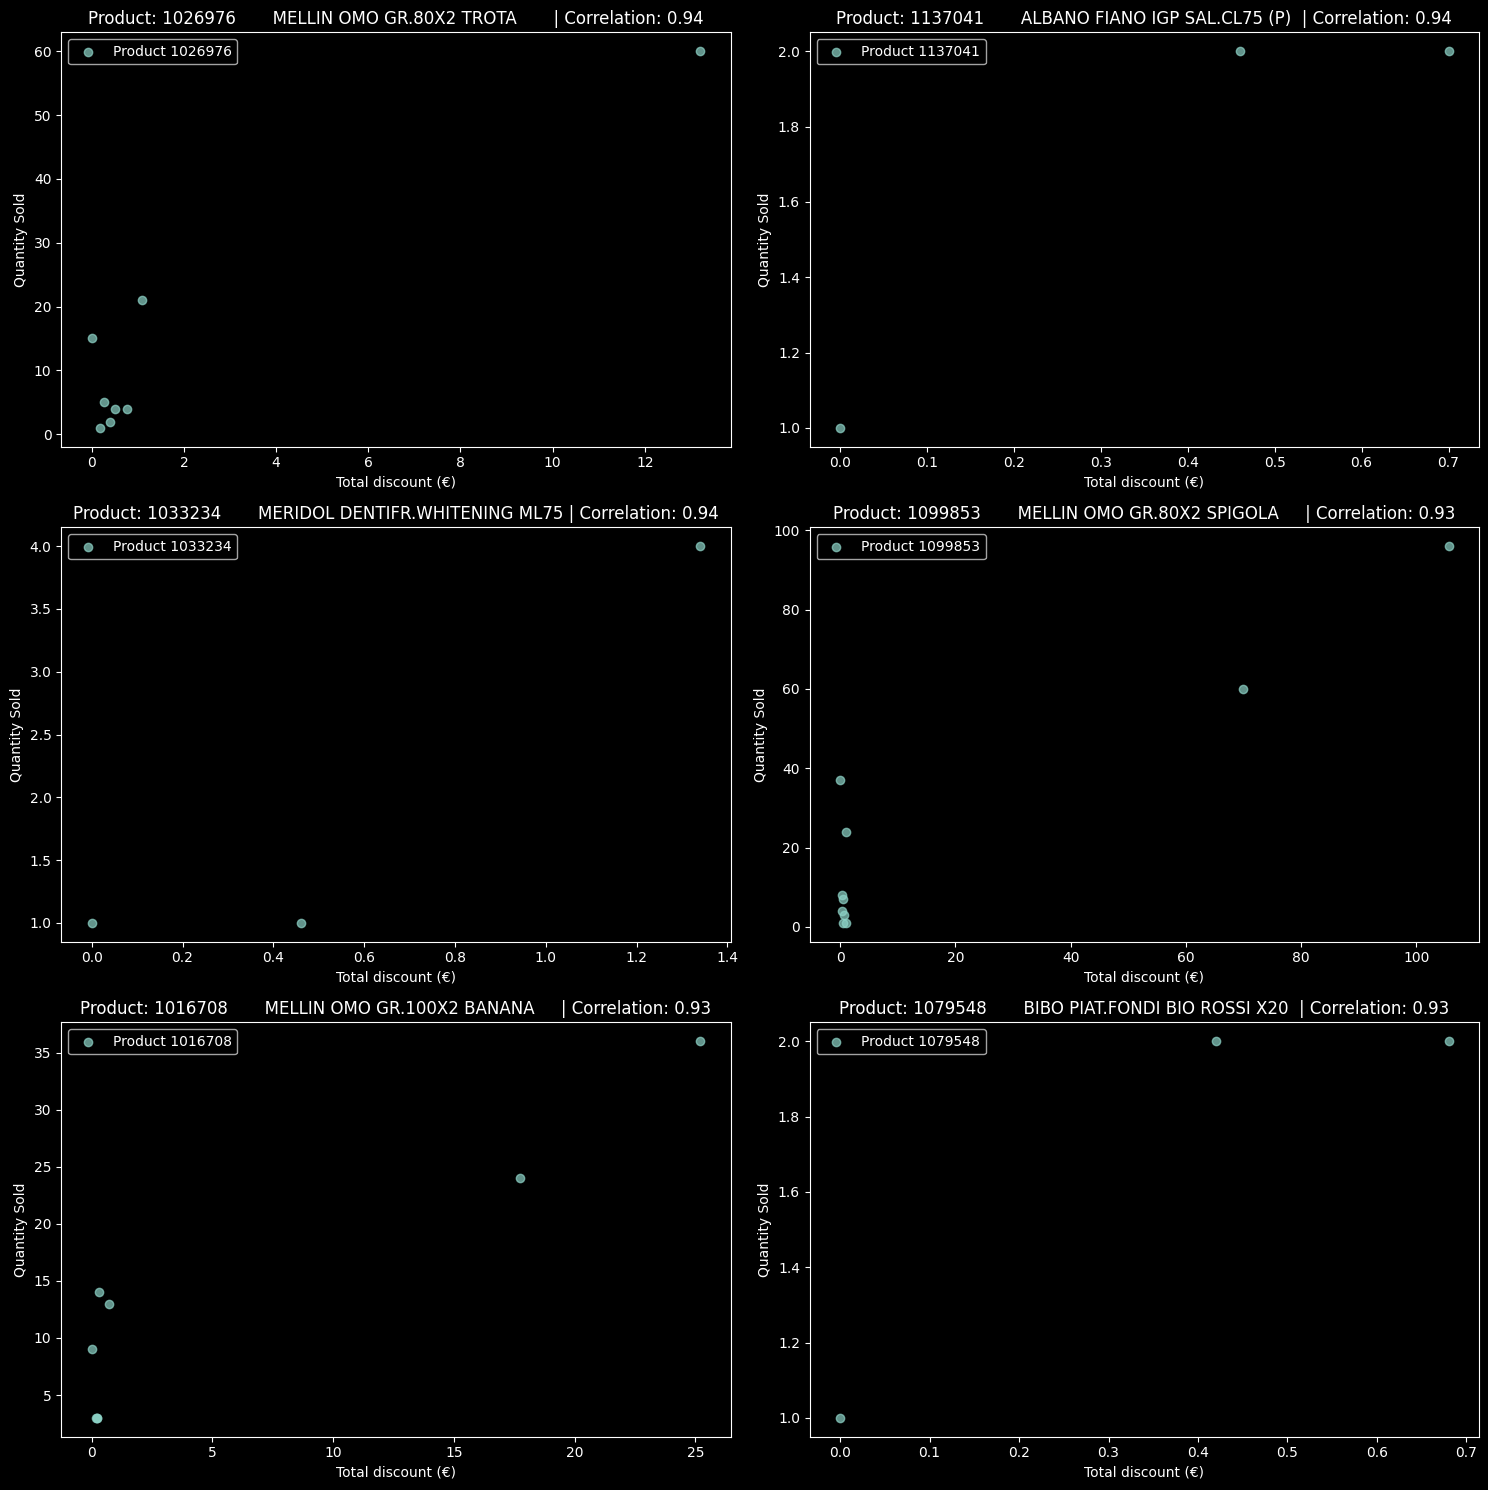

In [44]:
plot_top_products_on_sales(top_n_product_codes_with_discount(n = n, min_correlation=0.9, max_correlation=0.95))

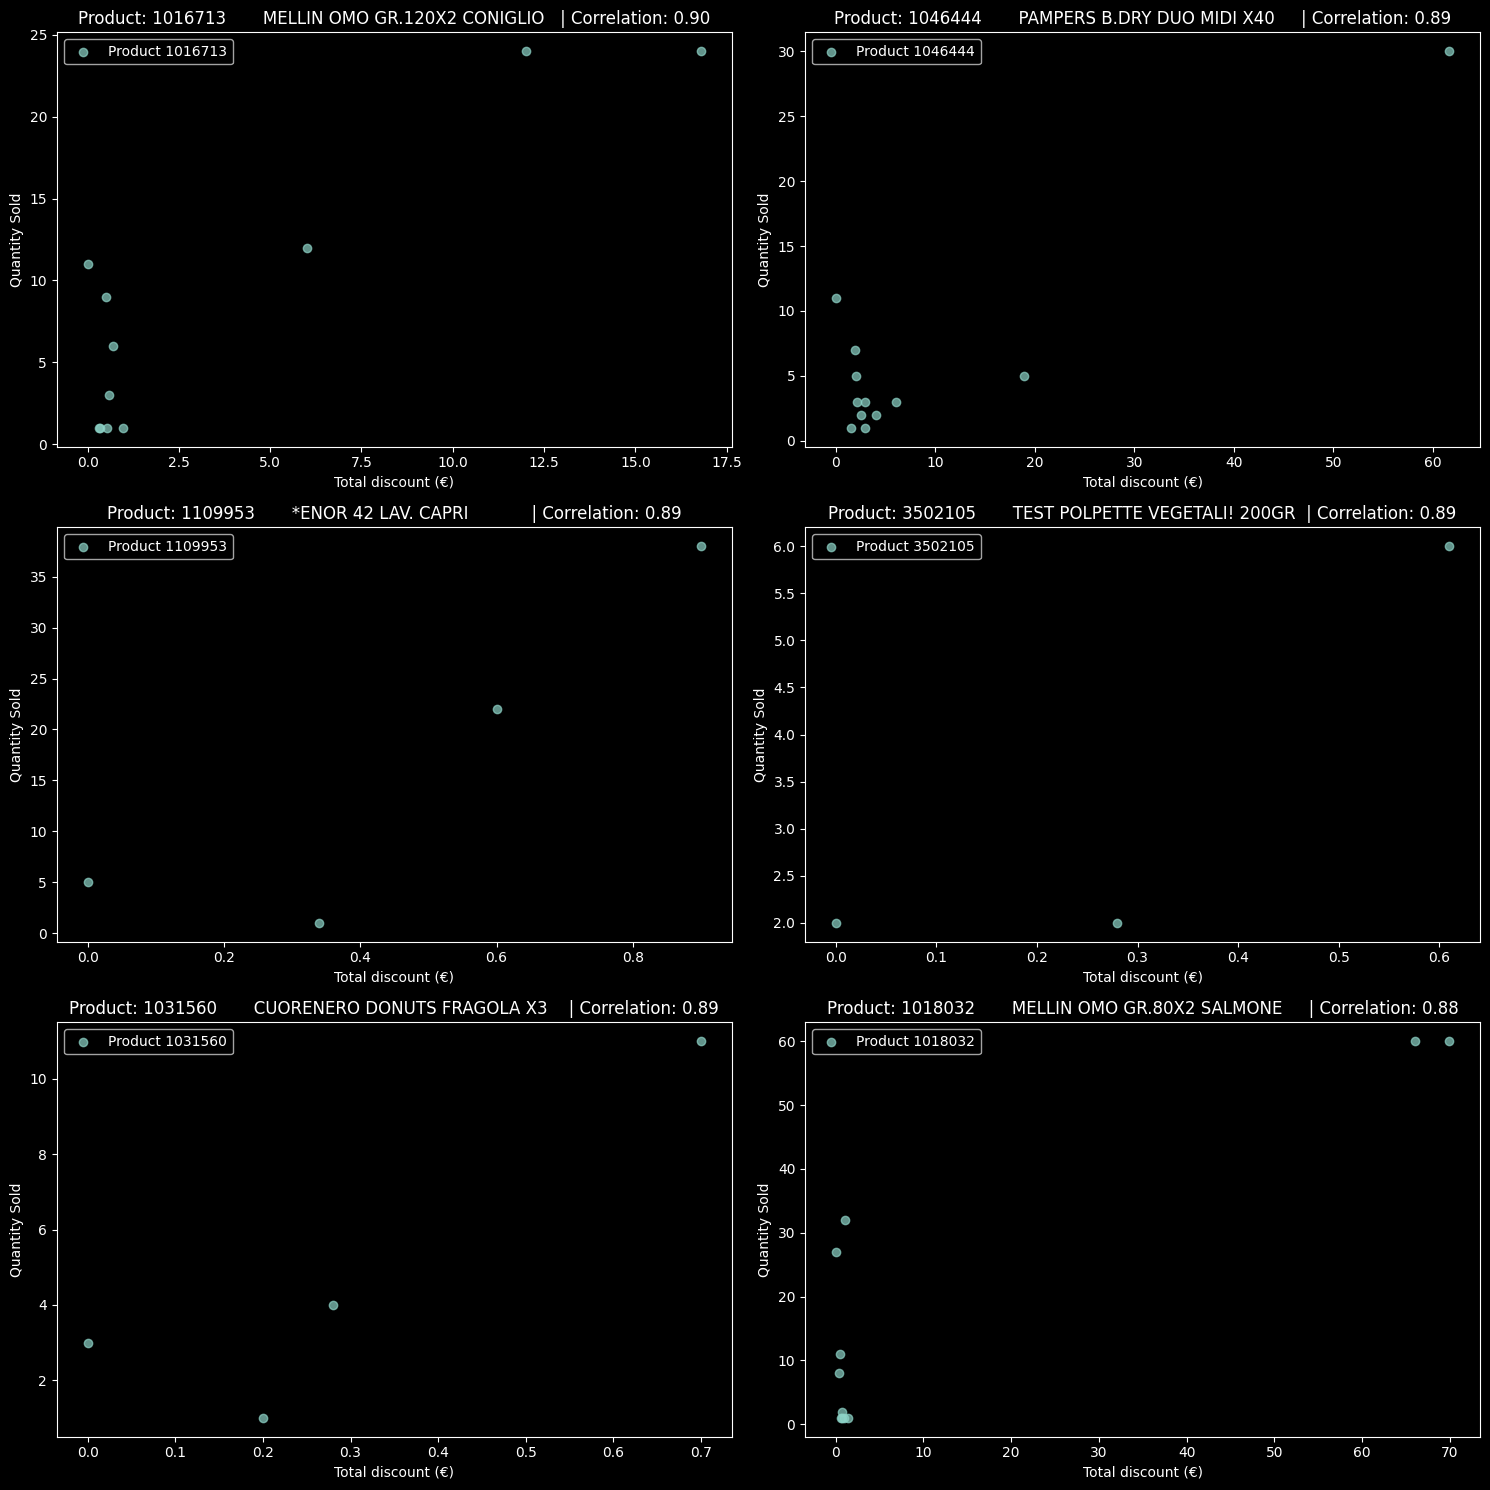

In [45]:
plot_top_products_on_sales(top_n_product_codes_with_discount(n = n, min_correlation=0.85, max_correlation=0.90))

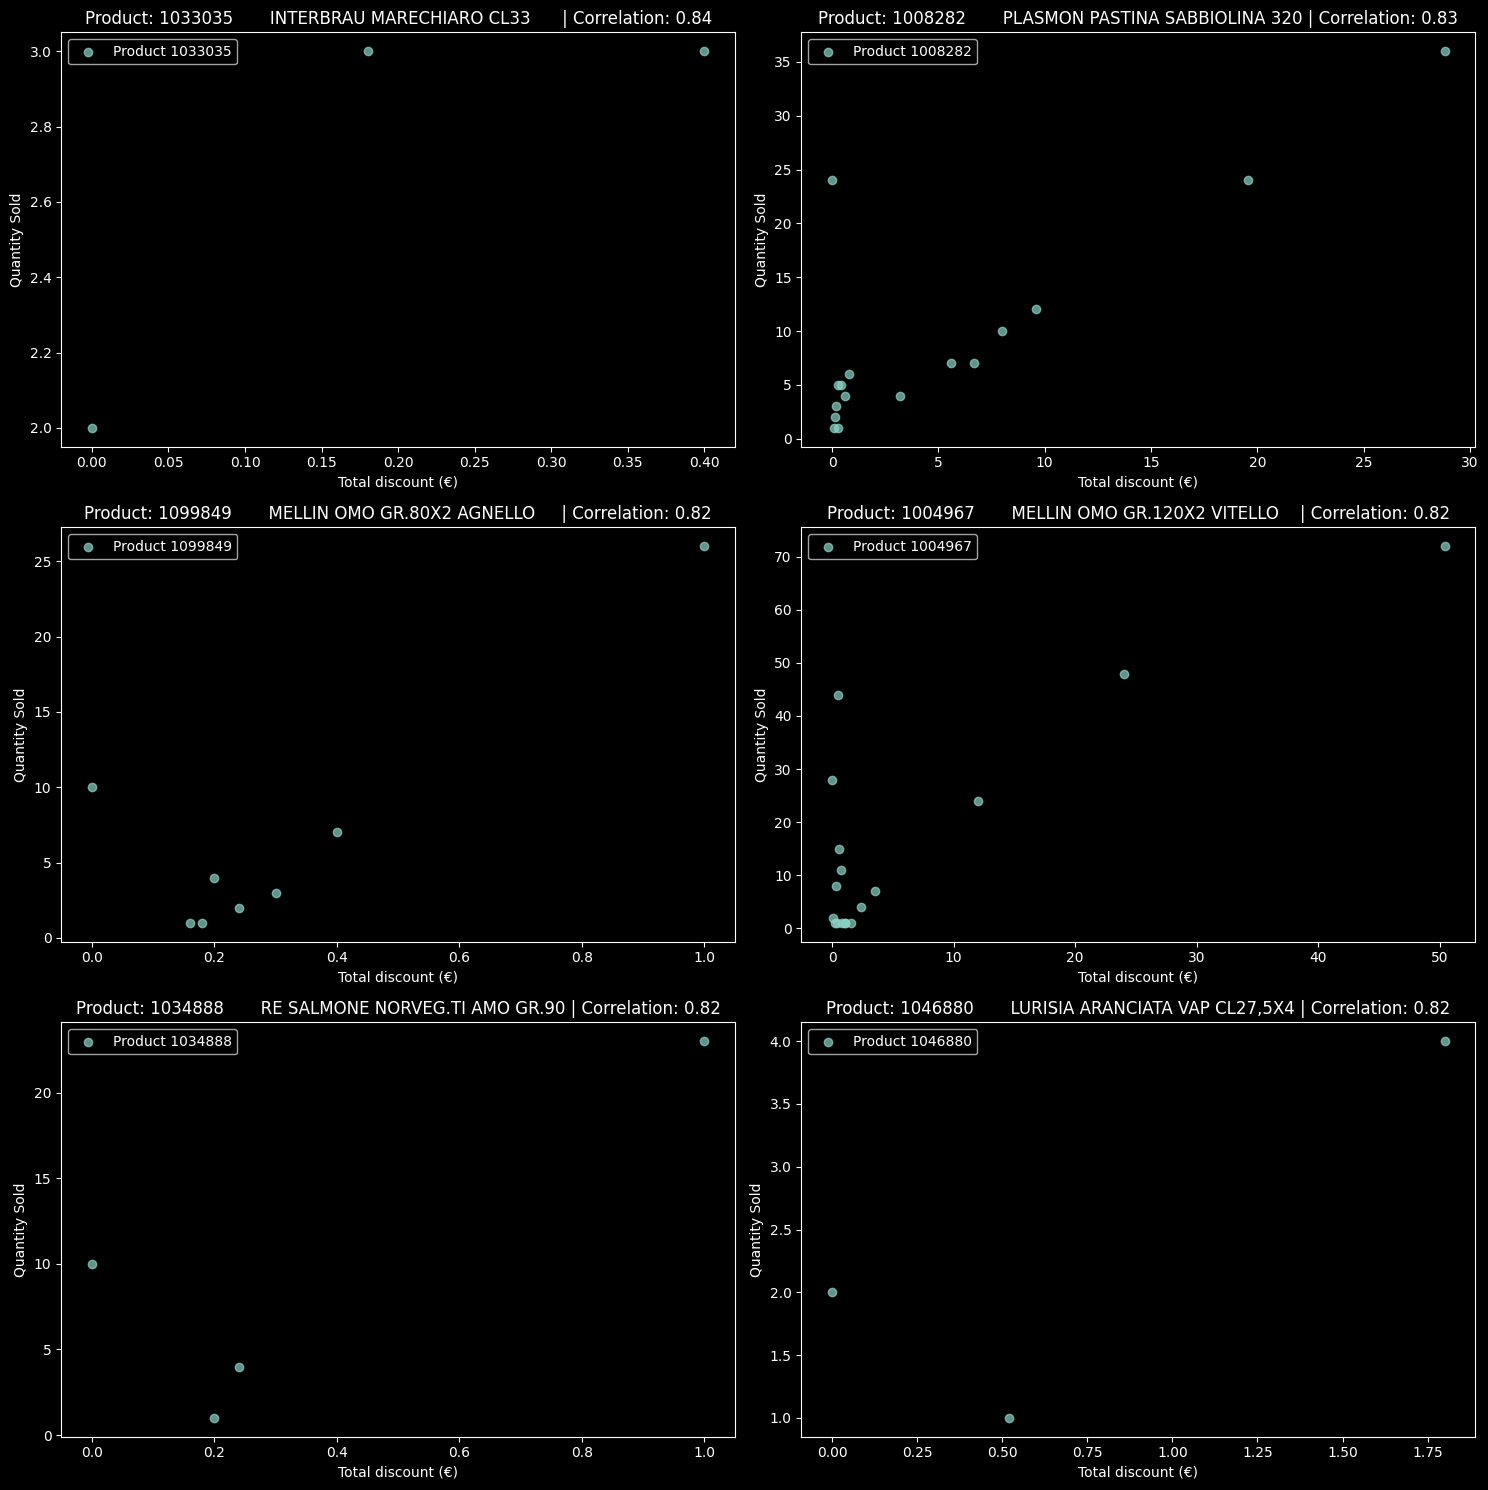

In [46]:
plot_top_products_on_sales(top_n_product_codes_with_discount(n = n, min_correlation=0.8, max_correlation=0.85))

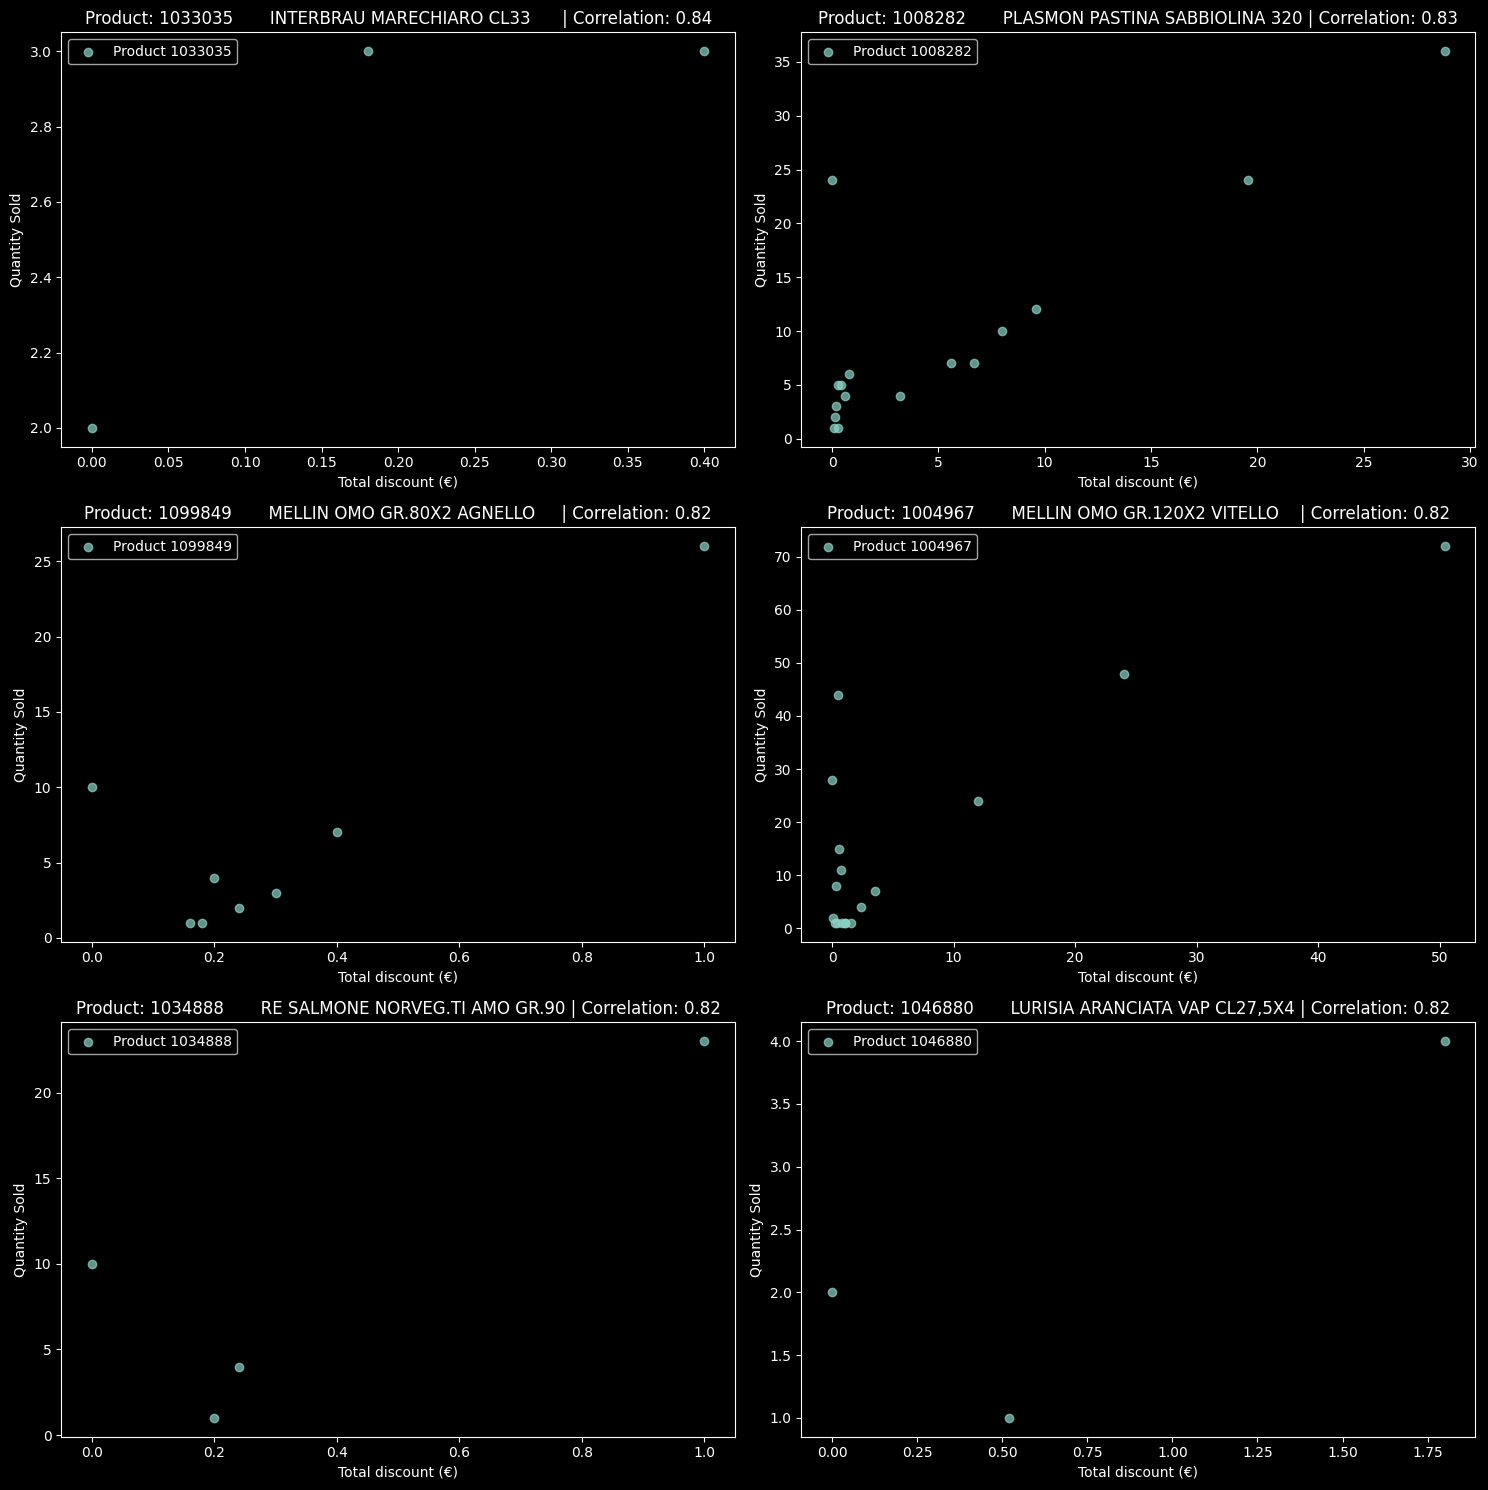

In [47]:
plot_top_products_on_sales(top_n_product_codes_with_discount(n = n, max_correlation=0.85))

We discovered that products for infants, such as baby food and diapers, tend to sell significantly better when discounted. This behavior can be attributed to the high demand for these essential items and the price sensitivity of customers purchasing them. 

Parents are more likely to stock up on infant products when discounts are available, as these items are necessities and often purchased in bulk.

Here are some products that sell better when there is less discount.

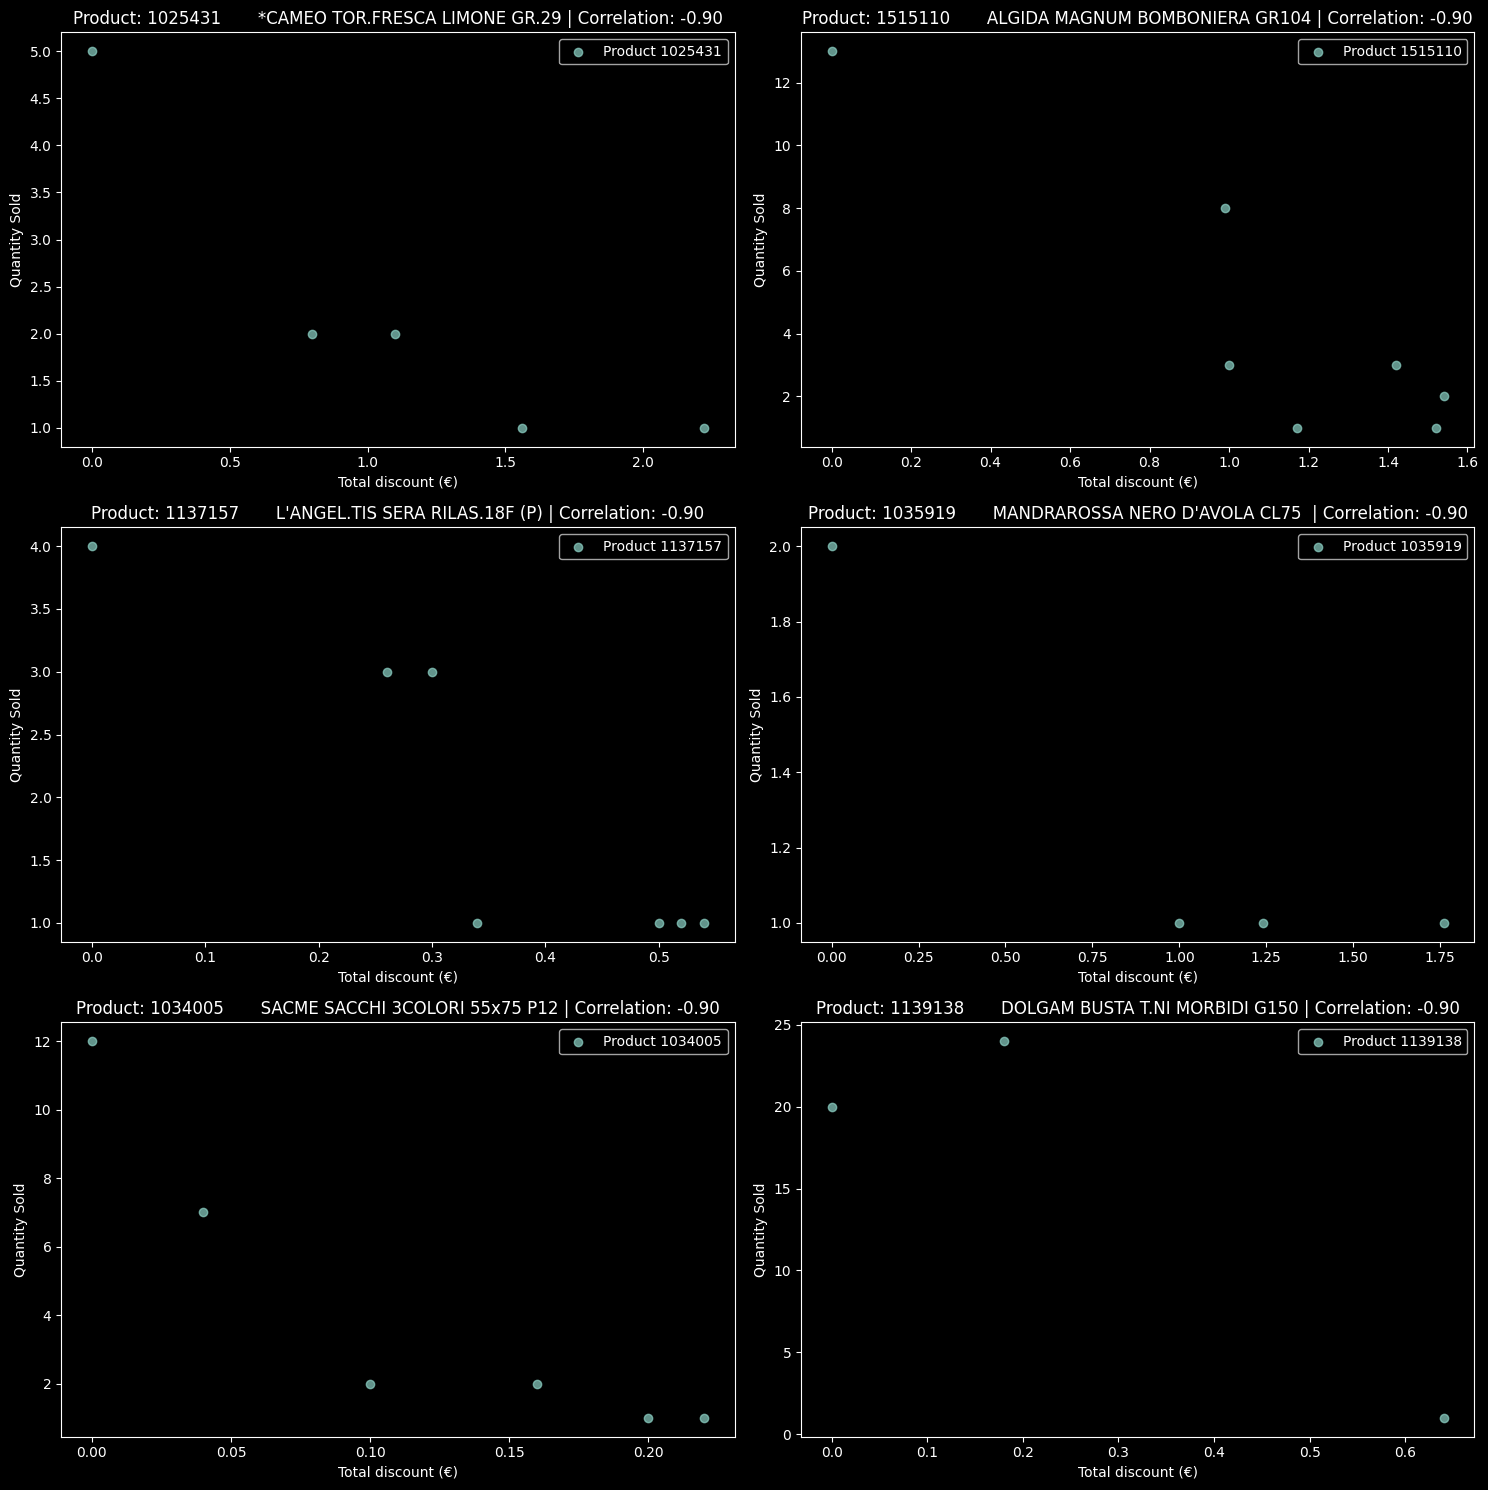

In [48]:
plot_top_products_on_sales(top_n_product_codes_with_discount(n = n, min_correlation=-1, max_correlation=-0.9))

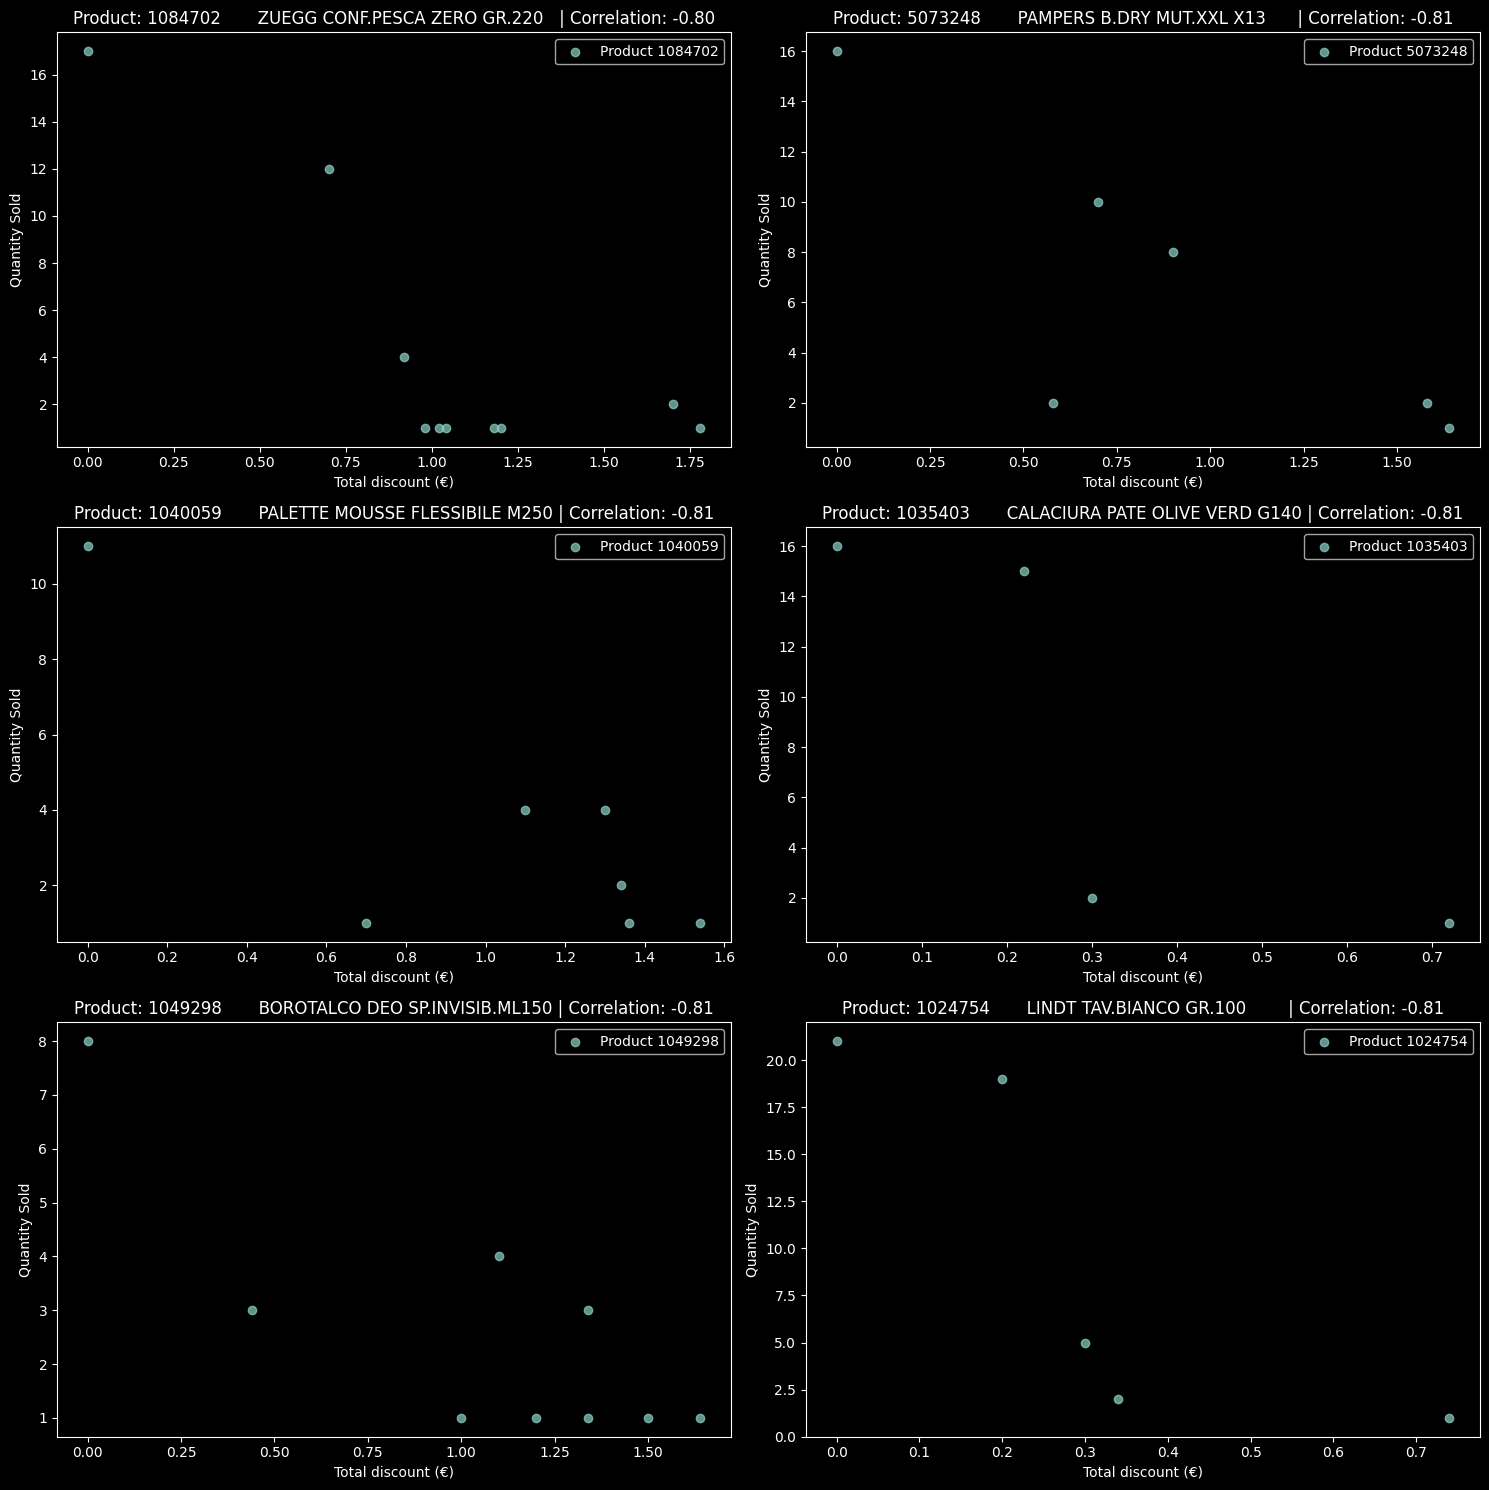

In [49]:
plot_top_products_on_sales(top_n_product_codes_with_discount(n = n, min_correlation=-0.9, max_correlation=-0.8))

# Answering question 2

**_Which products show signs of untapped sales potential?_**


To address this question, we can analyze products that perform well during sales and identify similar products that are underperforming. By comparing their characteristics, we can uncover untapped sales potential and develop targeted strategies to improve their performance.

Fortunately, the dataset includes the following columns to group products by similarity:
- `level1_id`
- `level1_description`
- `level2_id`
- `level2_description`
- `level3_id`
- `level3_description`
- `level4_id`
- `level4_description`

As we move deeper into the description levels (from level1 to level4), the product descriptions become increasingly detailed. Here is an example of description for a random product in the df.

In [51]:
random_product = df.sample(1)
print(random_product[['product_code', 'product_description', 
                      'level1_description', 'level2_description', 
                      'level3_description', 'level4_description']].T)

                                                          1218918
product_code                                            1003474.0
product_description  1003474       GALBANI SALAME UNGHERESE KG.4 
level1_description                                         FRESCO
level2_description                                         SALUMI
level3_description                            SALUMI BANCO TAGLIO
level4_description                                         SALAME


We identify the best-selling products by analyzing those with a high correlation between the quantity sold and the discount applied. Conversely, products with a low correlation are considered improvable, as they show limited responsiveness to discounts.

In [52]:
# products with correlation between 0.85 and 0.95
top_product_codes = top_n_product_codes_with_discount(n = np.inf, min_correlation=0.85, max_correlation=0.95)
top_product_codes = list(set(top_product_codes))

# products with correlation between -0.05 and 0.05
improvable_product_codes = top_n_product_codes_with_discount(n = np.inf, min_correlation=-0.05, max_correlation=0.05)
improvable_product_codes = list(set(improvable_product_codes))

In [53]:
print("Number of products with correlation between 0.85 and 0.95:", len(top_product_codes))
print("Number of products with correlation between -0.05 and 0.05:", len(improvable_product_codes))

Number of products with correlation between 0.85 and 0.95: 29
Number of products with correlation between -0.05 and 0.05: 257


To identify improvable products, we focus on a specific `level_description` (e.g., `level2_description`). We first extract the `level2_description` values associated with top-performing products. Using these values, we filter out improvable products that do not share the same `level_description` as the top products. Finally, we group the remaining improvable products by their `level_description` for further analysis.

In [54]:
def create_typology_dataframe(level_number):
    """
    Create a dataframe with columns: product_code, product_name, levelN_description, and typology (good, improvable).

    Parameters:
        level_number (int): The level number (1, 2, 3, or 4) to use for the level description.

    Returns:
        pd.DataFrame: A dataframe with the specified columns.
    """
    if level_number not in [1, 2, 3, 4]:
        raise ValueError("Invalid level number. Please choose 1, 2, 3, or 4.")
    
    # Construct the column name for the specified level
    level_column = f"level{level_number}_description"
    
    # Filter the relevant columns and drop duplicates
    product_to_level_n = df[['product_code', 'product_description', level_column]].drop_duplicates()
    
    # Create dataframes for top and improvable products
    top_products_df = pd.DataFrame({
        'product_code': top_product_codes,
        'typology': 'good'
    }).merge(product_to_level_n, on='product_code', how='left')
    
    improvable_products_df = pd.DataFrame({
        'product_code': improvable_product_codes,
        'typology': 'improvable'
    }).merge(product_to_level_n, on='product_code', how='left')
    
    # Concatenate the two dataframes
    combined_df = pd.concat([top_products_df, improvable_products_df], ignore_index=True)
    return combined_df


Here is an example output of the `create_typology_dataframe` function. Next, we will use this information to group products that belong to the same category level but have different typologies ("improvable" vs. "good"). This approach helps us identify underperforming products that are similar to top performers within the same category, highlighting opportunities for improvement.

In [60]:
create_typology_dataframe(1)

product_code    typology                           product_description  \
0         1016708        good  1016708       MELLIN OMO GR.100X2 BANANA       
1         1031560        good  1031560       CUORENERO DONUTS FRAGOLA X3      
2         1031560        good  1031560       *UORENERO DONUTS FRAGOLA X3      
3         1016713        good  1016713       MELLIN OMO GR.120X2 CONIGLIO     
4         1070091        good  1070091       PALETTE BALS.SALONPLEX ML.440    
..            ...         ...                                           ...   
343       1036793  improvable  1036793       PAVESI NEW RINGO NOCCIOLA G165   
344       1131002  improvable  1131002       ZUEGG SKIPPER ARANCIA BRIK LT1   
345       1055227  improvable  1055227       MELEG.DOLCI BOLL.PAND.+SPUM.     
346       1028597  improvable  1028597       *AMM.BARATTOLINO STRACC.GR.500   
347       1028597  improvable  1028597       SAMM.BARATTOLINO STRACC.GR.500   

       level1_description  
0    DROGHERIA ALIMENTARE  
1    DROGHERIA ALIMENTARE  
2    DROGHERIA ALIMENTARE  
3    DROGHERIA ALIMENTARE  
4            CURA PERSONA  
..                    ...  
343  DROGHERIA ALIMENTARE  
344               BEVANDE  
345  DROGHERIA ALIMENTARE  
346                FREDDO  
347                FREDDO  

[348 rows x 4 columns]

In [ ]:
def find_improvable_products(level_number):
    """
    Find and display improvable products based on the specified level number.
    """
    
    if level_number not in [1, 2, 3, 4]:
        raise ValueError("Invalid level number. Please choose 1, 2, 3, or 4.")
    
    # Construct the column name for the specified level
    level_column = f"level{level_number}_description"
    
    print(f"\nFinding improvable products for {level_column}...")
    
    typology_df = create_typology_dataframe(level_number)
    
    # level descriptions that are in the good typology
    valid_level_description_values = typology_df[typology_df['typology'] == 'good'][level_column].unique()
    
    # Filter out rows with invalid level description values
    typology_df = typology_df[typology_df[level_column].isin(valid_level_description_values)]

    # Filter for improvable products
    improvable_df = typology_df[typology_df['typology'] == 'improvable']
    # Group by level description
    grouped_df = improvable_df.groupby(level_column)
    
    total_number_of_products = improvable_df.shape[0]
    print(f"\nNumber of improvable products: {total_number_of_products}")
    
    # Display the count of improvable products per group
    for category, group in grouped_df:
        print(f"\nCategory: {category}")
        print("Products:")
        for _, row in group.iterrows():
            print(f"    - {row['product_description']}")
            

In [56]:
find_improvable_products(1)


Finding improvable products for level1_description...

Number of improvable products: 284

Category: BEVANDE
Products:
    - 1024514       SANTANNA ACQUA NATURALE LT.2  
    - 1006616       POWERADE BLOOD ORANGE CL.50 (P
    - 1082392       PERONI GR.RIS. BIANCA CL.50   
    - 1078318       LEFFE BLONDE CL.33            
    - 1006648       SETTESOLI NERO D'AVOLA CL. 75 
    - 1109568       COCA COLA ZERO VAP CL.25X4    
    - 1023568       TAVERNELLO BRICK ROSATO LT.1  
    - 1048149       ROCCA DEI FORTI SPUM.DOLCE C75
    - 1006676       STOCK CREMA LEMONCE' CL.50    
    - 1082480       COCA COLA PET LT.1,35X2  (P)  
    - 1049712       FIRRIATO VINO CHARME B. CL.75 
    - 1046666       SETTESOLI COLLEZIONE B.CL.75  
    - 1012897       CAFFO VECCHIO AMARO CAPO CL.70
    - 1077927       SANTANNA THE' LIMONE LT.1,5   
    - 1077927       *ANTANNA THE' LIMONE LT.1,5   
    - 1008298       PERONI BIRRA CL.33X3          
    - 1084600       FIRRIATO VINO CHARME ROSE'CL75
    - 1041610

In [57]:
find_improvable_products(2)


Finding improvable products for level2_description...

Number of improvable products: 110

Category: APERITIVI
Products:
    - 1081036       CRODINO ARANCIA ROSSA CL.10X10
    - 1105706       SANTERO 958 APERITIVO MIX CL75
    - 1037160       BACARDI BREEZER ORANGE CL.25  

Category: CAPELLI
Products:
    - 1058395       GLISS SHA.SETA LUMINOSA ML.250
    - 1032808       GARNIER UD HAIR MANDORLA 340ML
    - 1034477       U.DOLCE BALSAMO CAMOMILLA M200

Category: CHAMPAGNE/SPUMANTE
Products:
    - 1048149       ROCCA DEI FORTI SPUM.DOLCE C75
    - 1037104       DUCH.CUVEE BRUT SPUMANTE CL75 

Category: CIBI INFANZIA
Products:
    - 1062424       *LASMON BISC.ADULTO CER GR 270
    - 1062424       PLASMON BISC.ADULTO CER GR 270
    - 1017623       PLASMON OMO GR.80X2 CONIGLIO  
    - 1017624       PLASMON OMO GR.80X2 TACCHINO  

Category: CURA DEI TESSUTI
Products:
    - 1001489       ACE CANDEGGINA REGOLARE LT.4  
    - 1037848       COCCOLINO CONC.76LAV.DEL&SOFF.
    - 1034812       LE

In [58]:
find_improvable_products(3)


Finding improvable products for level3_description...

Number of improvable products: 51

Category: ACCESSORI TAVOLA USA E GETTA
Products:
    - 1135755       GOLD PL.PIAT.PIANO NICE ROS X6
    - 1079546       BIBO PIATTI BIO ROSSI DESS.X20
    - 1079546       BIBO PIATTI DESS.BIO.ROSSI X20
    - 1033074       NAPPAGE 12 PIATTI 100%NAT.CM18

Category: AMMORBIDENTI
Products:
    - 1037848       COCCOLINO CONC.76LAV.DEL&SOFF.
    - 1034812       LENOR 86LAV.ORO & FIORI       
    - 1119312       LENOR 54LAV PORTOFINO         
    - 1038841       LENOR 54LAV ORO & FIORI       
    - 1041692       VERNEL AMM.CONC.YLANGYLANG1,15
    - 1038738       LENOR 25LAV ELISIR PUGLIA     
    - 1038739       LENOR 25LAV ELISIR SARDEGNA   
    - 1033668       LENOR 25LAV ELISIR CALABRIA   
    - 1109960       *ENOR 65 LAV. GELS.SCARLATTO  
    - 1109965       *ENOR 65 LAV. SENSITIVE       

Category: APERITIVI ALCOLICI
Products:
    - 1105706       SANTERO 958 APERITIVO MIX CL75
    - 1037160       B

In [59]:
find_improvable_products(4)


Finding improvable products for level4_description...

Number of improvable products: 38

Category: ALTRI
Products:
    - 1081599       BREF BRILLANTE CANDEGGINA650ML

Category: ALTRI GUSTI
Products:
    - 1032830       GRANAROLO OHMYYOMO AGR&CIOC140
    - 1030301       MULLER YOG.BACIO GR 125X2     
    - 1030301       MULLER YOG.BACIO 2X125GR      
    - 1030301       *ULLER YOG.BACIO 2X125GR      
    - 1041610       TOMARCHIO LA ROSSA PET LT1,25 
    - 1041618       S.BENEDETTO GING.BIONDO 0 25X4
    - 1026315       NESQUIK MIX CHOCOBALLS GR 120 

Category: APERITIVI SODATI
Products:
    - 1105706       SANTERO 958 APERITIVO MIX CL75
    - 1037160       BACARDI BREEZER ORANGE CL.25  

Category: APERTO
Products:
    - 1040753       PAMPERS S/L PD JUNIORx30 11-25

Category: BALSAMO TRADIZIONALE
Products:
    - 1034477       U.DOLCE BALSAMO CAMOMILLA M200

Category: BIANCO
Products:
    - 1049712       FIRRIATO VINO CHARME B. CL.75 
    - 1046666       SETTESOLI COLLEZIONE B.CL.75  


As we increase the granularity of product descriptions, the number of improvable products decreases. This observation suggests that broader categories may mask underperforming products, while more detailed classifications help isolate specific items for improvement. 

# Answering question 3

**_Can we identify distinct types of shopping days throughout the year?_**

Each day is visualized as a time series, with each line representing a single day. The x-axis corresponds to the hours of the day, ranging from 8:00 AM to 10:00 PM, while the y-axis represents the total revenue generated during each hour.

In [55]:
clustering_features = [
    "receipt_id",
    "date",
    "time",
    "gross_amount",
    'discount', 
    'loyalty_discount', 
    'split_discount'
]

df_clustering = df[clustering_features]
df_clustering = df_clustering.dropna()

# Quantize the time to the hour. For instance, 10:30 becomes the string 10:00 - 11:00
df_clustering = df_clustering.assign(
    time=(
        pd.to_datetime(df_clustering['time'], format='%H:%M')
        .dt.floor('H')
        .apply(lambda t: f"{t.strftime('%H:%M')} - {(t + pd.Timedelta(hours=1)).strftime('%H:%M')}")
    )
)

# compute the total discont
df_clustering['net_price'] = df_clustering['gross_amount'] - (df_clustering['discount'] + df_clustering['loyalty_discount'] + df_clustering['split_discount'])
# drop the discount columns
df_clustering.drop(columns=['discount', 'loyalty_discount', 'split_discount'], inplace=True)

# compute revenue per date and hour
df_clustering = df_clustering.groupby(['date', 'time']).agg({'net_price': 'sum'}).reset_index()

# sort by date and time string
df_clustering = df_clustering.sort_values(by=['date', 'time'])

df_clustering = df_clustering.pivot(index='date', columns='time', values='net_price')

# replace NaN with 0
df_clustering = df_clustering.fillna(0)

df_clustering[:2]

/var/folders/hw/957djps540j8ld7pxmv_yf400000gn/T/ipykernel_80167/671082989.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .dt.floor('H')


time        08:00 - 09:00  09:00 - 10:00  10:00 - 11:00  11:00 - 12:00  \
date                                                                     
2023-01-02           0.00         186.99         736.02         736.47   
2023-01-03          51.21         301.26         711.38        1733.90   

time        12:00 - 13:00  13:00 - 14:00  14:00 - 15:00  15:00 - 16:00  \
date                                                                     
2023-01-02        1079.34         910.31         258.24         339.71   
2023-01-03        1871.07         985.77         371.21         447.45   

time        16:00 - 17:00  17:00 - 18:00  18:00 - 19:00  19:00 - 20:00  \
date                                                                     
2023-01-02         727.41        1070.00        1319.53        1141.25   
2023-01-03        1116.36        1266.51         950.47        1381.53   

time        20:00 - 21:00  21:00 - 22:00  
date                                      
2023-01-02         780.72          34.60  
2023-01-03         849.58          49.25

In [56]:
def plot_time_series(
    X, 
    title='Time Series of Gross Amount by Hour for Each Day',
    ylabel='Gross Amount (€)',
    clusters=None
):
    # Prepare the figure
    plt.figure(figsize=(15, 8))

    # Number of time series = number of rows
    num_series = len(X)

    # Decide how to color the lines
    if clusters is None:
        # Use a "jet" colormap across all time series
        colors = plt.cm.jet(np.linspace(0, 1, num_series))
    else:
        # Use a discrete color map (tab10) keyed by cluster label
        unique_clusters = np.unique(clusters)
        num_clusters = len(unique_clusters)
        color_map = plt.cm.get_cmap('tab10', num_clusters)
        # Build a dict mapping cluster IDs -> colors
        color_dict = {cluster_id: color_map(i) for i, cluster_id in enumerate(unique_clusters)}
        # For each row, pick its cluster color
        colors = [color_dict[c] for c in clusters]
        plt.legend(loc='best')
        

    # Plot each row (one time series per date)
    for i, (row_label, row_values) in enumerate(X.iterrows()):
        plt.plot(X.columns, row_values, color=colors[i], alpha=0.5, label=row_label)
        
    plt.title(title)
    plt.xlabel('Hour of the Day')
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.grid(True)
    # If the data is numeric hours, you can set ticks as you like, e.g. plt.xticks(range(8, 23))
    plt.tight_layout()
    plt.show()


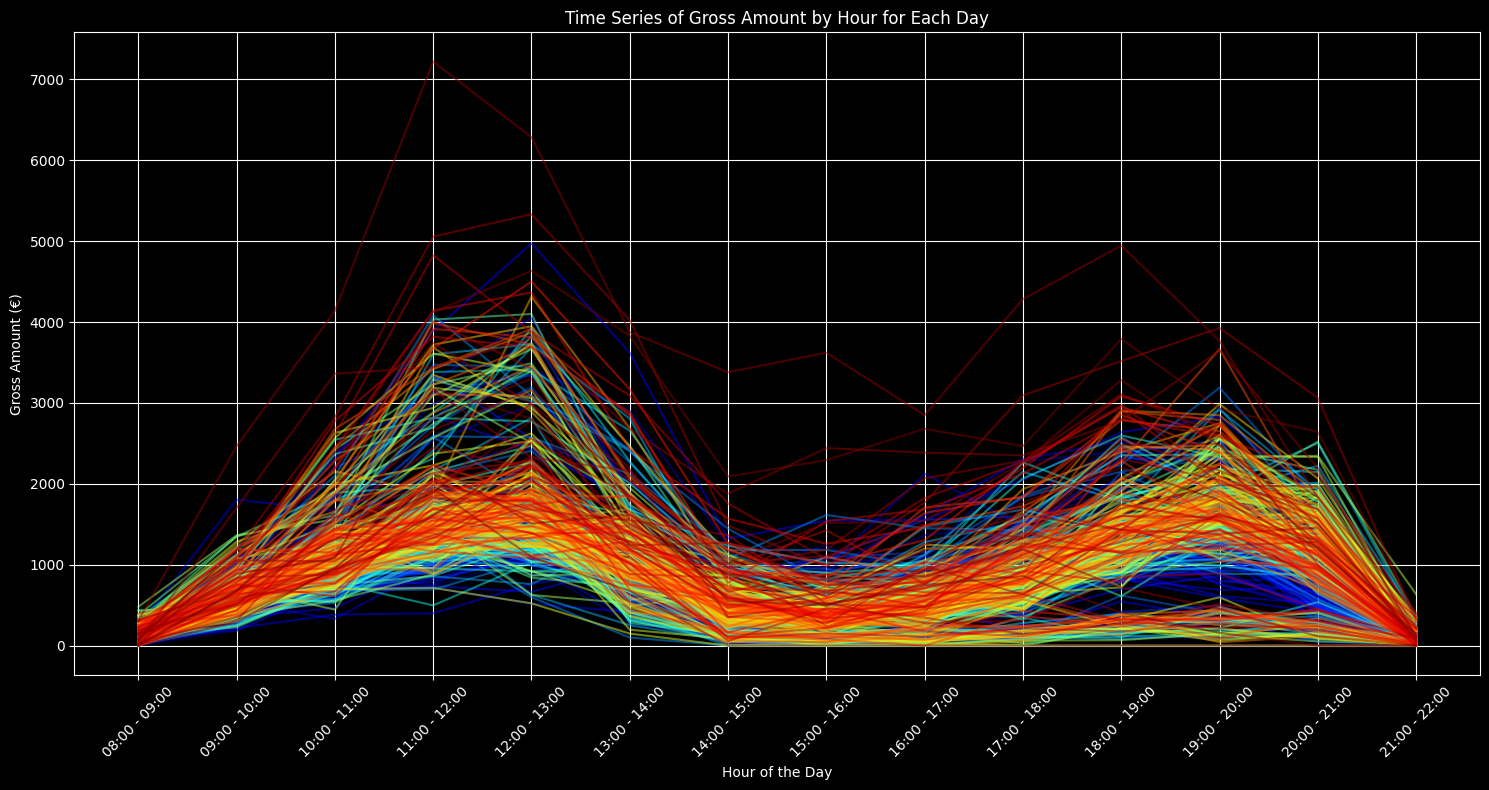

In [57]:
plot_time_series(
    df_clustering,
    title='Time Series of Gross Amount by Hour for Each Day',
    ylabel='Gross Amount (€)',
)

Before applying clustering, it is beneficial to use PCA (Principal Component Analysis) to reduce the dimensionality of the data while retaining most of its variance. This step simplifies the dataset, enhances computational efficiency, and helps visualize patterns more effectively.

In [58]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pca = PCA(n_components=None)
df_clustering_scaled = scaler.fit_transform(df_clustering.select_dtypes(include=[np.number]))
df_clustering_pca = pca.fit_transform(df_clustering_scaled)


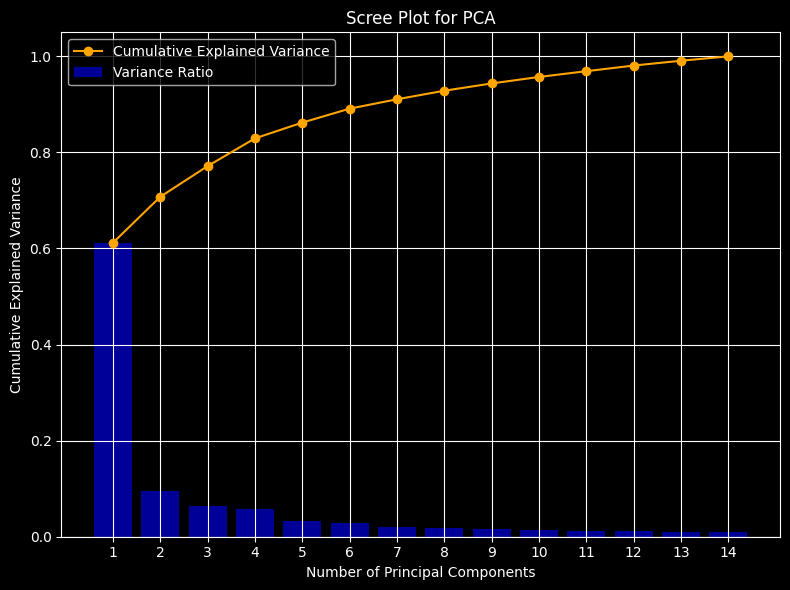

In [59]:

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio)+1), explained_variance_ratio, alpha=0.6, color='blue', label='Variance Ratio')
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', color='orange', label='Cumulative Explained Variance')
plt.xticks(range(1, len(explained_variance_ratio)+1))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot for PCA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [60]:
variance_threshold = 0.95
num_components = np.argmax(cumulative_variance >= variance_threshold) + 1
print(f"Number of components to explain {variance_threshold*100}% of the variance: {num_components}")

Number of components to explain 95.0% of the variance: 10


In [61]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

def plot_pca(
    df_clustering_pca,
    explained_variance_ratio,
    clusters=None,
    plot_3d=False
):
    """
    Plots PCA results either in 2D (matplotlib) or 3D (plotly).
    
    Parameters
    ----------
    df_clustering_pca : array-like, shape (n_samples, n_components)
        The PCA-transformed data.
    explained_variance_ratio : array-like, shape (n_components,)
        The ratio of variance explained by each of the selected components.
    clusters : array-like or None, optional
        Cluster labels for each sample. If provided, points of the same cluster
        will have the same color. If None, all points will be the same color.
    plot_3d : bool, optional
        If True, creates a 3D PCA scatter plot. If False, creates a 2D plot.
    """
    
    if clusters is None:
        # If no cluster labels are provided, default to a single color
        single_color = 'lightblue'
        cluster_colors = single_color
    else:
        # If we do have cluster labels, use them directly for coloring
        # (matplotlib will interpret them as discrete categories in 2D;
        #  plotly can interpret them as well in 3D)
        cluster_colors = clusters
    
    if not plot_3d:
        # Compute the explained variance (just for labeling; uses first 2 for consistency)
        explained_variance = np.round(np.sum(explained_variance_ratio[:2]), 2) * 100
        # ---- 2D Matplotlib Plot ----
        plt.figure(figsize=(10, 6))
        plt.scatter(
            df_clustering_pca[:, 0],
            df_clustering_pca[:, 1],
            c=cluster_colors
        )
        plt.title(f'PCA 2D Plot - {explained_variance}% explained variance')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.show()
        
    else:
        
        # Compute the explained variance (just for labeling; uses first 2 for consistency)
        explained_variance = np.round(np.sum(explained_variance_ratio[:3]), 2) * 100
        # ---- 3D Plotly Plot ----
        title = f'PCA 3D Plot - {explained_variance}% explained variance'
        fig = go.Figure()
        
        fig.add_trace(go.Scatter3d(
            x=df_clustering_pca[:, 0],
            y=df_clustering_pca[:, 1],
            z=df_clustering_pca[:, 2],
            mode='markers',
            marker=dict(
            size=6,
            opacity=0.8,
            # Use cluster_colors if available, otherwise a single color
            color=cluster_colors if clusters is not None else 'rgb(0,123,167)', # thanks Camilla for the color 🦭
            ),
            hoverinfo='text',
            text=[f"Date: {date}" for date in df_clustering.index]
        ))
        
        fig.update_layout(
            template='plotly_dark',
            title=title,
            scene=dict(
                xaxis_title="Component 1",
                yaxis_title="Component 2",
                zaxis_title="Component 3"
            )
        )
        
        fig.show()


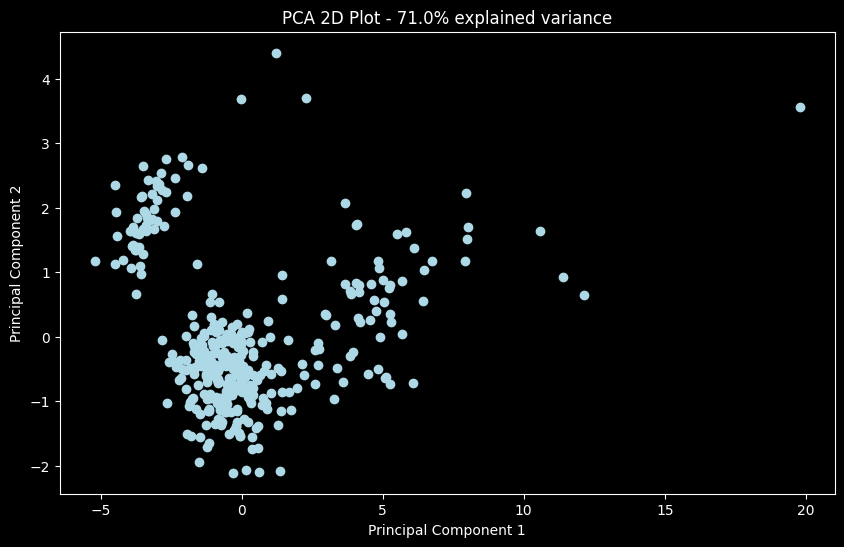

In [62]:
plot_pca(
    df_clustering_pca,
    explained_variance_ratio,
    plot_3d=False
)
plot_pca(
    df_clustering_pca,
    explained_variance_ratio,
    plot_3d=True
)

#### Number of cluster selection

Using up to three dimensions, it is visually challenging to determine the optimal number of clusters due to insufficient variance explained by the data. Therefore, we will rely on both the elbow method and silhouette analysis to make an informed selection.

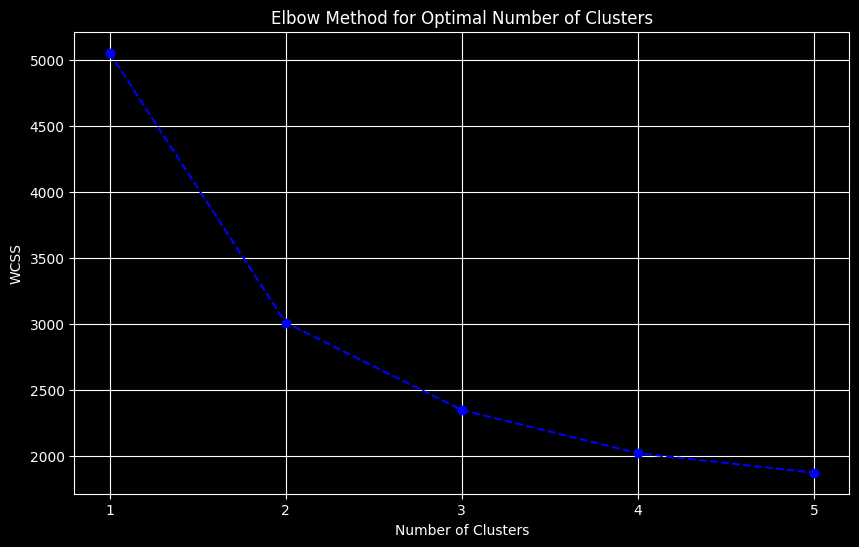

In [63]:
from sklearn.cluster import KMeans

# Calculate WCSS for different numbers of clusters
wcss = [] # Within-Cluster Sum of Squares
max_clusters = 5  # Define the maximum number of clusters to test
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_clustering_pca)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, max_clusters + 1))
plt.grid()
plt.show()

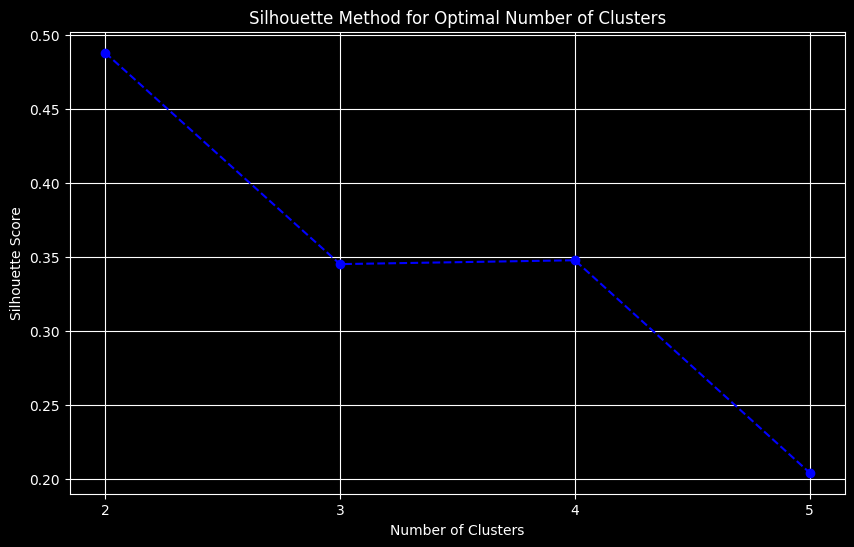

In [64]:
from sklearn.metrics import silhouette_score

def silhouette_score_subsample(X, labels, subsample_size=20000, random_state=None):
    """
    Compute silhouette score on a random subsample of the dataset.
    """
    if subsample_size >= X.shape[0]:
        # No need to subsample if the dataset is smaller than subsample_size
        return silhouette_score(X, labels)

    rng = np.random.default_rng(random_state)
    indices = rng.choice(X.shape[0], size=subsample_size, replace=False)
    X_sub = X[indices]
    labels_sub = labels[indices]

    return silhouette_score(X_sub, labels_sub)

silhouette_scores = []
max_clusters = 5
for n_clusters in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_clustering_pca)
    silhouette_avg = silhouette_score_subsample(df_clustering_pca, cluster_labels, subsample_size=5000, random_state=42)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', linestyle='--', color='b')
plt.title('Silhouette Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, max_clusters + 1))
plt.grid()
plt.show()

Based on the plots above, the optimal number of clusters appears to be 2.

In [65]:
# Perform KMeans clustering
optimal_clusters = 2  # Based on the silhouette and elbow methods
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(df_clustering_pca)

# Add cluster labels to the dataframe
df_clustering['cluster'] = cluster_labels

# Display the number of samples in each cluster
cluster_counts = df_clustering['cluster'].value_counts()
print("Number of samples in each cluster:")
print(cluster_counts)

Number of samples in each cluster:
cluster
0    300
1     61
Name: count, dtype: int64


/var/folders/hw/957djps540j8ld7pxmv_yf400000gn/T/ipykernel_80167/3968574868.py:21: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/var/folders/hw/957djps540j8ld7pxmv_yf400000gn/T/ipykernel_80167/3968574868.py:26: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



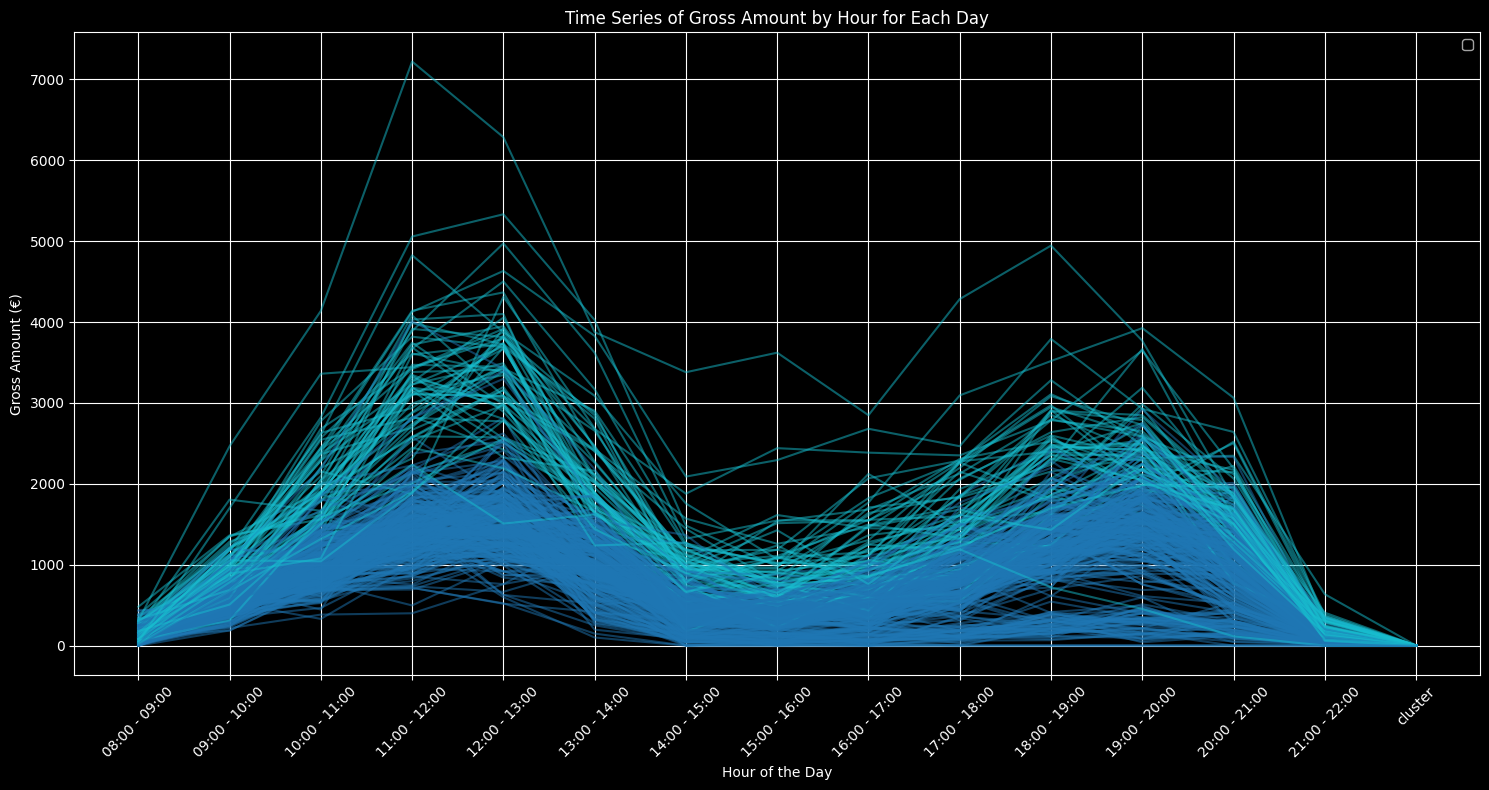

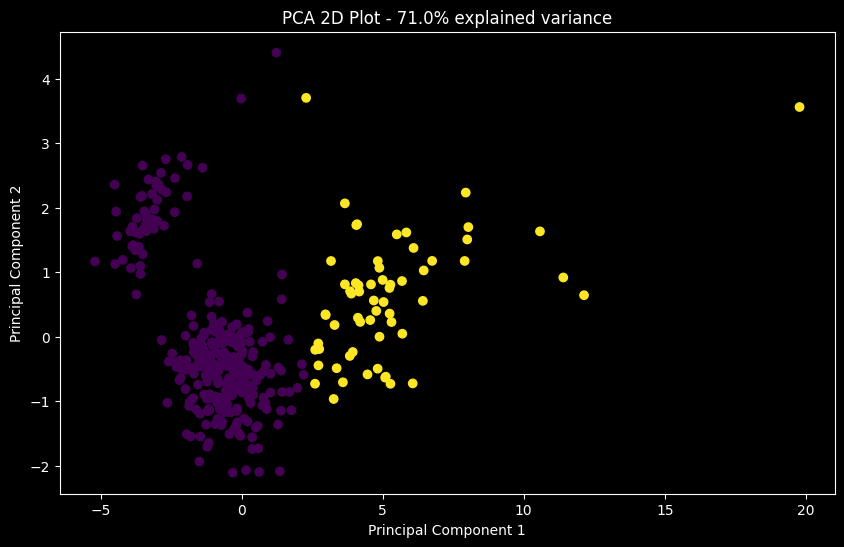

In [66]:
plot_time_series(
    df_clustering,
    title='Time Series of Gross Amount by Hour for Each Day',
    ylabel='Gross Amount (€)',
    clusters=cluster_labels
)
plot_pca(
    df_clustering_pca,
    explained_variance_ratio,
    clusters=cluster_labels
)
plot_pca(
    df_clustering_pca,
    explained_variance_ratio,
    clusters=cluster_labels,
    plot_3d=True
)

In [67]:
import datetime
def is_near_italian_holiday(date_to_check, days_range=1):
    """
    Check if a date is near an Italian public holiday and return the holiday name if applicable.
    
    Parameters:
        date_to_check (datetime.date): The date to check.
        days_range (int): How many days before or after a holiday counts as "near".
    
    Returns:
        tuple: (bool, str) where the first element indicates if the date is near a holiday,
                and the second element is the holiday name or an empty string if not near.
    """
        
    year = date_to_check.year
    # Convert date_to_check to datetime.date
    date_to_check = date_to_check.date()
    
    # Get Italian holidays for the specified year
    italian_holidays = holidays.IT(years=year) + holidays.IT(years=year + 1)
    

    # Build a set of dates that are within days_range of each holiday
    near_holiday_dates = {}
    for holiday_date, holiday_name in italian_holidays.items():
        for offset in range(0, days_range + 1):
            near_holiday_dates[holiday_date - timedelta(days=offset)] = holiday_name
    if date_to_check in near_holiday_dates:
        return True, near_holiday_dates[date_to_check]
    return False, ""


def clustering_statistics(df, cluster_labels):
    """
    Computes statistics for each cluster, including:
    - Count of days of the week
    - Mean daily revenue

    Parameters:
        df (pd.DataFrame): DataFrame where rows are dates, columns are hourly time slots,
                           and one 'cluster' column at the end.
        cluster_labels (np.ndarray or list): Cluster labels for each row.

    Returns:
        pd.DataFrame: A dataframe with day-of-week counts and mean revenue per cluster.
    """
    df = df.copy()
    df['cluster'] = cluster_labels

    # Add 'day_of_week' column
    df['day_of_week'] = pd.to_datetime(df.index).day_name()

    # Sum hourly revenue for each day
    hourly_columns = df.columns.difference(['cluster', 'day_of_week'])
    df['daily_revenue'] = df[hourly_columns].sum(axis=1)
    
    # Group by cluster
    day_counts = df.groupby(['cluster', 'day_of_week']).size().unstack(fill_value=0)

    # Reorder days of the week
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_counts = day_counts.reindex(columns=days_order, fill_value=0)

    # Compute mean revenue per cluster
    mean_revenue = df.groupby('cluster')['daily_revenue'].mean().round(2)
    max_revenue = df.groupby('cluster')['daily_revenue'].max().round(2)
    min_revenue = df.groupby('cluster')['daily_revenue'].min().round(2)
    std_revenue = df.groupby('cluster')['daily_revenue'].std().round(2)

    # Combine into one DataFrame
    result = day_counts.copy()
    result['mean_revenue'] = mean_revenue
    result['max_revenue'] = max_revenue
    result['min_revenue'] = min_revenue
    result['std_revenue'] = std_revenue
    
    # count how many days are near a holiday
    df['is_near_holiday'] = df.index.to_series().apply(lambda x: is_near_italian_holiday(pd.to_datetime(x), 3)[0])
    near_holiday_counts = df.groupby('cluster')['is_near_holiday'].sum()
    result['near_holiday_count'] = near_holiday_counts
    
    
    # sort by mean revenue
    result = result.sort_values(by='mean_revenue', ascending=False)
    
    # Create a dataframe to display holiday information for each cluster
    holiday_data = []
    for cluster in result.index:
        for date in df[df['cluster'] == cluster].index:
            is_near, holiday_name = is_near_italian_holiday(pd.to_datetime(date), 2)
            if is_near:
                holiday_data.append({'Cluster': cluster, 'Date': date, 'day_of_week': pd.to_datetime(date).day_name(), 'NearHoliday': holiday_name, 'Revenue': df.loc[date, 'daily_revenue']})
    
    holiday_df = pd.DataFrame(holiday_data)
    
    # sort by cluster (ASC) and Revenue (DESC)
    holiday_df = holiday_df.sort_values(by=['Cluster', 'Revenue'], ascending=[True, False])
    holiday_df = holiday_df.reset_index(drop=True)

    
    grouped = holiday_df.groupby(['Cluster', 'NearHoliday'], as_index=False).agg({'Revenue': 'sum'})

    # Plot top 10 most profitable NearHolidays for each cluster
    for cluster in grouped['Cluster'].unique():
        df_cluster = grouped[grouped['Cluster'] == cluster].sort_values('Revenue', ascending=False)
        plt.figure()
        plt.bar(df_cluster['NearHoliday'], df_cluster['Revenue'])
        plt.title(f'Cluster {cluster}: Top Holidays by Total Revenue')
        plt.ylabel('Total Revenue (€)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    display(result)
    

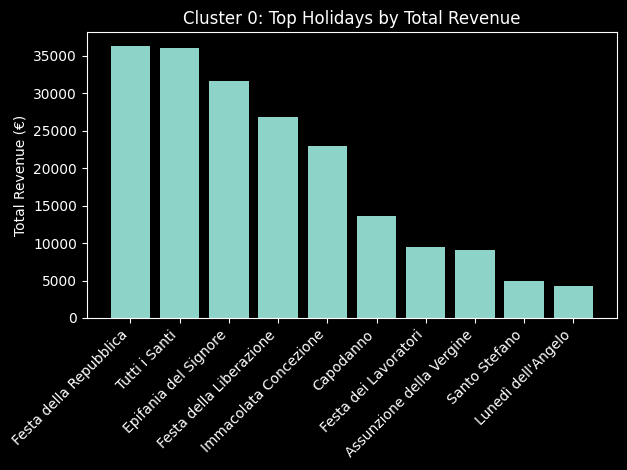

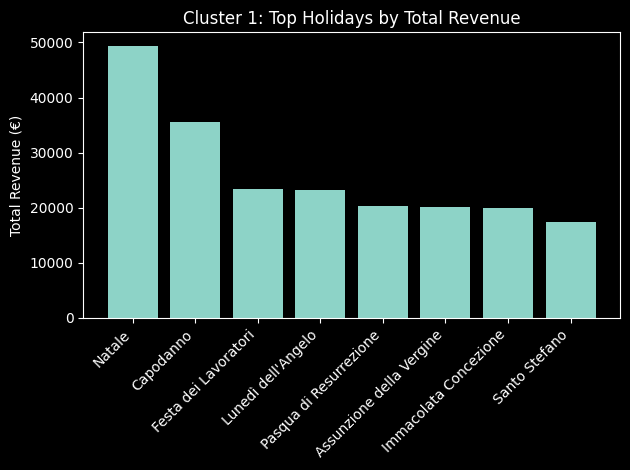

day_of_week  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday  \
cluster                                                                       
1                 2        1          1         3       4        49       1   
0                48       51         51        49      48         3      50   

day_of_week  mean_revenue  max_revenue  min_revenue  std_revenue  \
cluster                                                            
1                23322.48     49375.55     17236.48      5215.04   
0                11050.86     17539.36      2675.74      2790.91   

day_of_week  near_holiday_count  
cluster                          
1                            12  
0                            26

In [68]:
clustering_statistics(df_clustering, cluster_labels)


Based on the clustering analysis, the answer is **yes**: the data clearly shows that distinct types of days emerge throughout the year, with measurable differences in both temporal distribution and revenue behavior.
The dataset was clustered into two main groups, and their composition reveals a strong correlation between the day of the week and the nature of the revenue generated. 

One cluster (Cluster 0) is composed predominantly of weekdays, Monday through Friday, while the other (Cluster 1) consists almost entirely of Saturdays. This separation suggests that Saturdays behave fundamentally differently from other days.

From a revenue perspective, the contrast between the two clusters is even more pronounced. Cluster 1, dominated by Saturdays, shows a mean daily revenue of over €23,000, which is more than double the mean of Cluster 0 (around €11,000). Moreover, Cluster 1 exhibits significantly higher maximum values and standard deviation, indicating not only higher spending but also greater variability in customer behavior. These could correspond to shopping peaks, special events, or simply the nature of weekend consumer habits.
Interestingly, while Sundays are present in both clusters, their distribution is uneven, suggesting that some Sundays behave like Saturdays, while others align more with weekdays. This dual behavior could be influenced by specific dates (e.g. holidays, sales events, or post-holiday weekends).

The clustering reveals two well-separated profiles of days: one that reflects routine business activity and another characterized by exceptional revenue patterns, likely linked to weekend dynamics. This distinction supports the idea that days across the calendar year are not homogeneous, and in particular, that Saturdays represent a structurally different kind of day in terms of revenue behavior.

A closer examination of the distribution of dates near public holidays further reinforces this interpretation. The table above lists dates from both clusters that either fall directly on or just before significant Italian holidays. What stands out is that Cluster 1, the one associated with higher, more volatile revenue, includes several Saturdays and pre-holiday dates, such as the day before Pasqua (Easter), Festa dei Lavoratori (Labour Day), Assunzione della Vergine (Assumption Day), Immacolata Concezione (Immaculate Conception), and Natale (Christmas). These dates typically coincide with heightened consumer activity, which may explain the observed revenue spikes.
On the other hand, Cluster 0 contains dates that are more evenly distributed across weekdays and include the holidays themselves (e.g., Epifania, Santo Stefano, Festa della Repubblica, and Tutti i Santi) or the days immediately before or after them. The presence of Sundays, midweek holidays, and bridge days (e.g., April 24th, the day before the Festa della Liberazione) in this cluster suggests a pattern of regular or slightly elevated business activity, but not to the extent observed in Cluster 1.
This distribution implies that Cluster 1 captures days of anticipation or preparation, where consumers might be making purchases ahead of a holiday or during a weekend spree, while Cluster 0 includes the holidays themselves or quieter surrounding days. The clustering has therefore succeeded not only in separating weekdays from high-activity Saturdays but also in isolating days that precede major national holidays—days that often carry distinct commercial behavior. This adds a further layer of nuance: it’s not just the type of day (weekday vs. weekend) that matters, but also its proximity to culturally or economically significant moments in the calendar.

To investigate more on different types of days, let's consider 3 clusters.

In [69]:
# Perform KMeans clustering
optimal_clusters = 3  # Based on the silhouette and elbow methods
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(df_clustering_pca)

# Add cluster labels to the dataframe
df_clustering['cluster'] = cluster_labels

/var/folders/hw/957djps540j8ld7pxmv_yf400000gn/T/ipykernel_80167/3968574868.py:21: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/var/folders/hw/957djps540j8ld7pxmv_yf400000gn/T/ipykernel_80167/3968574868.py:26: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



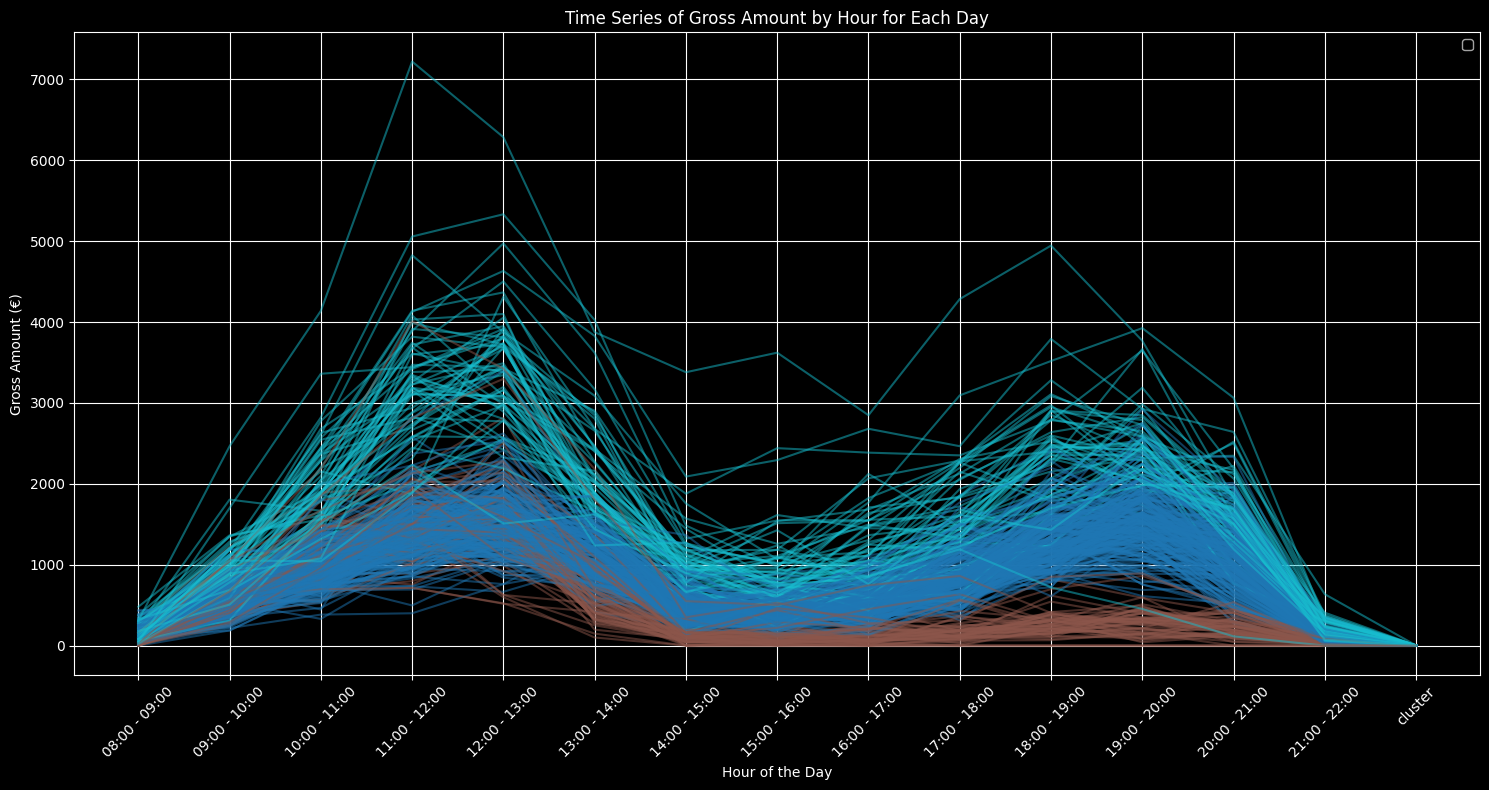

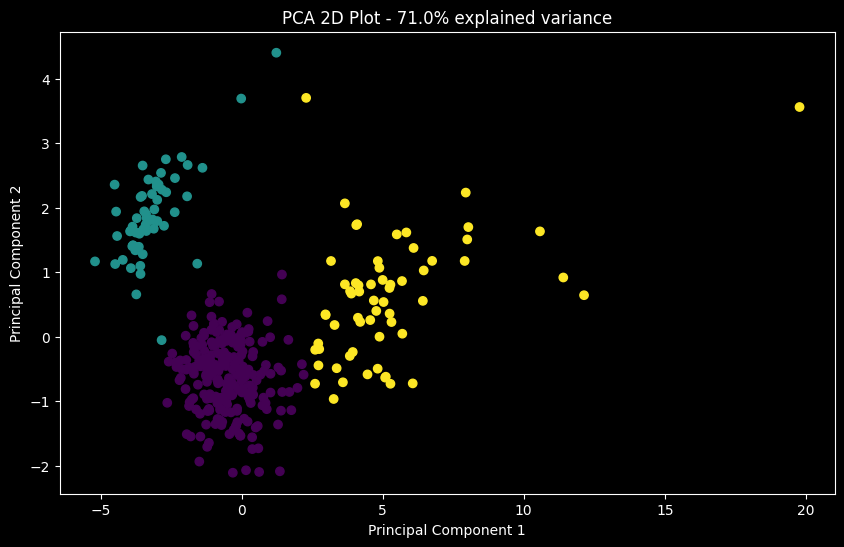

In [70]:
plot_time_series(
    df_clustering,
    title='Time Series of Gross Amount by Hour for Each Day',
    ylabel='Gross Amount (€)',
    clusters=cluster_labels
)
plot_pca(
    df_clustering_pca,
    explained_variance_ratio,
    clusters=cluster_labels
)
plot_pca(
    df_clustering_pca,
    explained_variance_ratio,
    clusters=cluster_labels,
    plot_3d=True
)

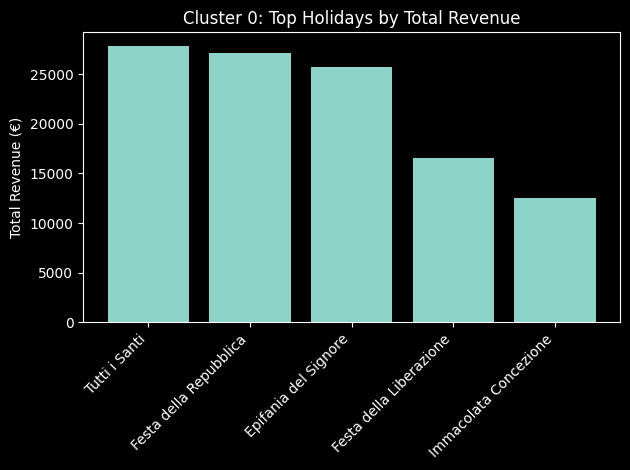

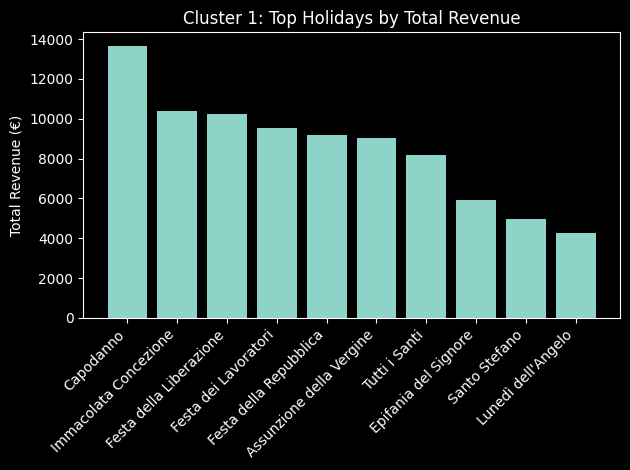

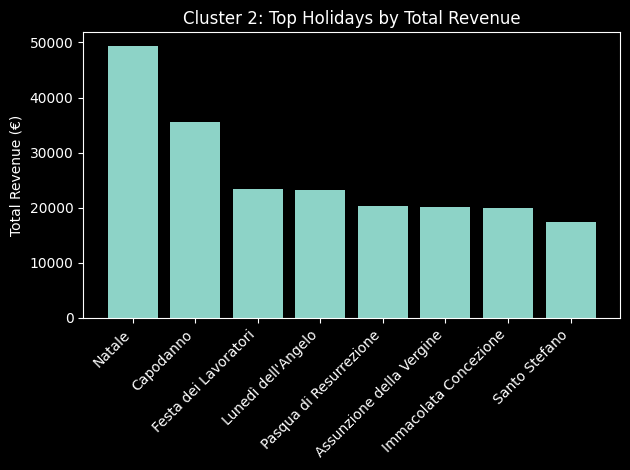

day_of_week  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday  \
cluster                                                                       
2                 2        1          1         3       4        49       1   
0                47       47         49        48      45         3       0   
1                 1        4          2         1       3         0      50   

day_of_week  mean_revenue  max_revenue  min_revenue  std_revenue  \
cluster                                                            
2                23322.48     49375.55     17236.48      5215.04   
0                12085.79     17539.36      7691.33      1836.63   
1                 6995.99     16613.30      2675.74      2110.24   

day_of_week  near_holiday_count  
cluster                          
2                            12  
0                            13  
1                            13

In [71]:
clustering_statistics(df_clustering, cluster_labels)

In this case, the cluster with the most profitable days (Cluster 0) remains consistent with the previous analysis. However, the new cluster (Cluster 2) predominantly contains Sundays. Interestingly, Sundays are not the most profitable days, with a mean revenue of almost €7,000, compared to weekdays, which have a mean revenue of €12,000.

# Answering question 4

**_Can we build a model to classify whether a product purchase is likely to involve a discount?_**

In [203]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

We select a subset of features for the classification.

In [204]:
df_classification = df.copy()
df_classification = df_classification.drop(columns=[
    'db_id', 
    'receipt_id', 
    'store_id', 
    'checkout_id', 
    'cashier_id', 
    'receipt_number', 
    'fidelity', 
    'card_flag', 
    'row_number', 
    'department_code', 
    'ean_code',
    'row_type',
    'tax_percentage',
    'taxable_amount',
    'supplier_code',
    'product_category',
    'supplier_description',
    'level1_description',
    'level2_description',
    'level3_description',
    'level4_description',
    'typology_description', 
    'position_code', 
    'position_description', 
    'typology'
])

In [205]:
# sort by date
df_classification = df_classification.sort_values(by=['date', 'time'])

In [206]:
display(df_classification.head(100))

date   time  quantity_pieces    weight  gross_amount  discount  \
11540  2023-01-02  09:11                1  0.000000          5.77      0.82   
11541  2023-01-02  09:11                1  0.000000          1.04      0.45   
11542  2023-01-02  09:11                1  0.000000          1.30      0.19   
11543  2023-01-02  09:11                1  0.000000          1.74      0.25   
11544  2023-01-02  09:11                1  0.000000          2.18      0.81   
...           ...    ...              ...       ...           ...       ...   
11631  2023-01-02  10:11                1  0.100000          1.59      0.00   
11632  2023-01-02  10:11                1  0.000000          1.09      0.00   
11633  2023-01-02  10:11                1  0.000000          1.99      1.20   
11634  2023-01-02  10:11                1  0.000000          1.09      0.00   
11635  2023-01-02  10:11                1  1.006711          1.50      0.00   

       loyalty_discount  split_discount  product_code  \
11540                 0            0.82     1023964.0   
11541                 0            0.15     1090318.0   
11542                 0            0.19     1002375.0   
11543                 0            0.25     1015557.0   
11544                 0            0.31     1023915.0   
...                 ...             ...           ...   
11631                 0            0.00     1047141.0   
11632                 0            0.00     1099750.0   
11633                 0            0.00     1008775.0   
11634                 0            0.00     1099755.0   
11635                 0            0.00     1028794.0   

                                product_description  level1_id  level2_id  \
11540  1023964       FINDUS MISTO MARE BIANCO GR400        4.0      402.0   
11541  1090318       SPRING BICCH.TRASP.CC.200 2X50        5.0      504.0   
11542  1002375       DOVE SAP.LIQ.RIC.ORIG.ML500 (P        6.0      602.0   
11543  1015557       SCALA CARTA CASA ASCIUG.4 ROT.        5.0      504.0   
11544  1023915       *EMPO CARTA IG.X 4 ROT.CONFORT        6.0      601.0   
...                                             ...        ...        ...   
11631  1047141       LEVONI MORTADELLA ORO KG. 13          3.0      306.0   
11632  1099750       MONTORSI BS SALAME MILANO GR60        3.0      306.0   
11633  1008775        GRANAR.MOZZARELLA GR.100X3           3.0      301.0   
11634  1099755       MONTORSI BS SPECK AFF. GR.60          3.0      306.0   
11635  1028794       F.BANANE CHIQUITA EXTRA               8.0      802.0   

       level3_id  level4_id  
11540    40206.0  4020606.0  
11541    50402.0  5040201.0  
11542    60201.0  6020101.0  
11543    50401.0  5040103.0  
11544    60105.0  6010502.0  
...          ...        ...  
11631    30604.0  3060405.0  
11632    30601.0  3060104.0  
11633    30101.0  3010102.0  
11634    30601.0  3060108.0  
11635    80220.0  8022001.0  

[100 rows x 14 columns]

The classifier will focus on products that do not have an associated weight. This decision is based on the observation that products with weights, such as fresh produce or meats

By excluding products with weights, the analysis can better target packaged goods, which are more likely to have consistent pricing and promotional strategies. This approach ensures that the model's predictions are more accurate and relevant for identifying discount-driven purchasing behavior in a controlled subset of products.

In [207]:
# number of unique products that have a weight greater than 0 
df_classification_weight = df_classification[df_classification['weight'] > 0]
print("Some products associeted to a weight:")
for _, row in islice(df_classification_weight.iterrows(), 10):
    print(f"    - {parse_prod_name(row['product_description'])[1]}")

Some products associeted to a weight:
    - F.BANANE CHIQUITA EXTRA
    - F.FINOCCHI
    - F.FINOCCHI
    - *.RADICCHIO TONDO ROSSO
    - F.BANANE CHIQUITA EXTRA
    - PANE GRANO TENERO VELLA
    -  GALBANI GALBANONE KG.5
    - CAVALCATORE PECORINO PS PEPATO
    - LEVONI MORTADELLA ORO KG. 13  
    - FERRARINI PROSC.COTTO EFFE AQ 


In [208]:
# remove products with weight greater than 0
df_classification = df_classification[df_classification['weight'] == 0]
# drop the weight column
df_classification.drop(columns=['weight'], inplace=True)

We also do not consider the `quantity_pieces` column since the classifier will work on a single product. Before removing the column, we normalize the `gross_amount` and all discount-related columns (`discount`, `loyalty_discount`, `split_discount`) by dividing their values by `quantity_pieces`. This ensures that the price and discount values are calculated on a per-unit basis, making the data consistent and comparable across all products.

Next, we proceed to drop the `quantity_pieces` column as it is no longer required for the classification task.

In [209]:
# Normalize the gross_amount and discount-related columns by dividing by quantity_pieces
df_classification['gross_amount'] = df_classification['gross_amount'] / df_classification['quantity_pieces']
df_classification['discount'] = df_classification['discount'] / df_classification['quantity_pieces']
df_classification['loyalty_discount'] = df_classification['loyalty_discount'] / df_classification['quantity_pieces']
df_classification['split_discount'] = df_classification['split_discount'] / df_classification['quantity_pieces']

# Drop the quantity_pieces column
df_classification.drop(columns=['quantity_pieces'], inplace=True)

We also exclude the year from our analysis and focus only on the month and day. Since the dataset spans only a single year, using the year as a feature would not generalize well to other years. By considering only the month and day, we ensure that the analysis can be applied to other years without introducing unnecessary bias or overfitting to the specific year in the dataset.

In [210]:
df_classification['month'] = pd.to_datetime(df_classification['date']).dt.month
df_classification['day'] = pd.to_datetime(df_classification['date']).dt.day

# remove the date column
df_classification.drop(columns=['date'], inplace=True)

# move the month and day columns to the beginning
cols = df_classification.columns.tolist()
cols.insert(0, cols.pop(cols.index('month')))
cols.insert(1, cols.pop(cols.index('day')))
df_classification = df_classification[cols]

display(df_classification.head(10))

month  day   time  gross_amount  discount  loyalty_discount  \
11540      1    2  09:11          5.77      0.82               0.0   
11541      1    2  09:11          1.04      0.45               0.0   
11542      1    2  09:11          1.30      0.19               0.0   
11543      1    2  09:11          1.74      0.25               0.0   
11544      1    2  09:11          2.18      0.81               0.0   
11546      1    2  09:11          3.49      0.50               0.0   
11547      1    2  09:11          6.04      3.86               0.0   
11548      1    2  09:11          1.13      0.16               0.0   
11549      1    2  09:11          3.41      0.48               0.0   
11550      1    2  09:11          0.41      0.06               0.0   

       split_discount  product_code  \
11540            0.82     1023964.0   
11541            0.15     1090318.0   
11542            0.19     1002375.0   
11543            0.25     1015557.0   
11544            0.31     1023915.0   
11546            0.50     1026550.0   
11547            0.86     1113174.0   
11548            0.16     1020437.0   
11549            0.48     1064124.0   
11550            0.06     1000521.0   

                                product_description  level1_id  level2_id  \
11540  1023964       FINDUS MISTO MARE BIANCO GR400        4.0      402.0   
11541  1090318       SPRING BICCH.TRASP.CC.200 2X50        5.0      504.0   
11542  1002375       DOVE SAP.LIQ.RIC.ORIG.ML500 (P        6.0      602.0   
11543  1015557       SCALA CARTA CASA ASCIUG.4 ROT.        5.0      504.0   
11544  1023915       *EMPO CARTA IG.X 4 ROT.CONFORT        6.0      601.0   
11546  1026550       *OTTA C.NONNO CAFFE NEW GR.288        4.0      401.0   
11547  1113174       *AULI P.NE CR.LIMONCELLO GR750        1.0      120.0   
11548  1020437       COTONEVE DISCHETTI STRUCCAN.70        6.0      601.0   
11549  1064124       AURICCHIO AURICCHIETTO GR.270         3.0      301.0   
11550  1000521       LETE ACQUA MINERALE LT. 1,5           2.0      201.0   

       level3_id  level4_id  
11540    40206.0  4020606.0  
11541    50402.0  5040201.0  
11542    60201.0  6020101.0  
11543    50401.0  5040103.0  
11544    60105.0  6010502.0  
11546    40103.0  4010305.0  
11547    12001.0  1200103.0  
11548    60101.0  6010104.0  
11549    30107.0  3010702.0  
11550    20103.0  2010306.0

It's time to defining the target variable `with_discount`:

The target variable `with_discount` is a boolean indicator that is set to `0` if a discount is applied to a product purchase, and `0` otherwise. This variable will be used to classify and analyze purchasing behavior in relation to discounts.

In [211]:
df_classification['with_discount'] = (
    (df_classification['discount'] + df_classification['loyalty_discount'] + df_classification['split_discount']) > 0
).astype(int)

Balance of the class to predict:

In [212]:

def discount_balance(df_classification):
    """
    Print the balance of the discount classes.
    """
    class_balance = df_classification['with_discount'].value_counts()
    print("\nClass balance:")
    for class_value, count in class_balance.items():
        print(f"Class {class_value}: {count} ({count / len(df_classification) * 100:.2f}%)")
        
discount_balance(df_classification)



Class balance:
Class 0: 976955 (56.40%)
Class 1: 755219 (43.60%)


The dataset is pretty balanced!

In [213]:
display(df_classification)

month  day   time  gross_amount  discount  loyalty_discount  \
11540        1    2  09:11          5.77      0.82               0.0   
11541        1    2  09:11          1.04      0.45               0.0   
11542        1    2  09:11          1.30      0.19               0.0   
11543        1    2  09:11          1.74      0.25               0.0   
11544        1    2  09:11          2.18      0.81               0.0   
...        ...  ...    ...           ...       ...               ...   
2232154     12   31  19:46          1.42      0.27               0.0   
2232155     12   31  19:46          1.42      0.27               0.0   
2232156     12   31  19:46          0.94      0.05               0.0   
2232157     12   31  19:46          1.51      0.08               0.0   
2232160     12   31  19:50          0.94      0.05               0.0   

         split_discount  product_code  \
11540              0.82     1023964.0   
11541              0.15     1090318.0   
11542              0.19     1002375.0   
11543              0.25     1015557.0   
11544              0.31     1023915.0   
...                 ...           ...   
2232154            0.07     3000304.0   
2232155            0.07     3000304.0   
2232156            0.05     1032042.0   
2232157            0.08     1041930.0   
2232160            0.05     1031271.0   

                                  product_description  level1_id  level2_id  \
11540    1023964       FINDUS MISTO MARE BIANCO GR400        4.0      402.0   
11541    1090318       SPRING BICCH.TRASP.CC.200 2X50        5.0      504.0   
11542    1002375       DOVE SAP.LIQ.RIC.ORIG.ML500 (P        6.0      602.0   
11543    1015557       SCALA CARTA CASA ASCIUG.4 ROT.        5.0      504.0   
11544    1023915       *EMPO CARTA IG.X 4 ROT.CONFORT        6.0      601.0   
...                                               ...        ...        ...   
2232154  3000304       TEST P.BRISEE S.O.PALMA 230G          3.0      308.0   
2232155  3000304       TEST P.BRISEE S.O.PALMA 230G          3.0      308.0   
2232156  1032042       LIFE ANACARDI NATUR. 0.99 35G         1.0      122.0   
2232157  1041930       EXQUISA FR CREMOSO LIGHT GR175        3.0      301.0   
2232160  1031271       LIFE MISTO SALATO 0.99 70G            1.0      122.0   

         level3_id  level4_id  with_discount  
11540      40206.0  4020606.0              1  
11541      50402.0  5040201.0              1  
11542      60201.0  6020101.0              1  
11543      50401.0  5040103.0              1  
11544      60105.0  6010502.0              1  
...            ...        ...            ...  
2232154    30802.0  3080204.0              1  
2232155    30802.0  3080204.0              1  
2232156    12203.0  1220307.0              1  
2232157    30111.0  3011101.0              1  
2232160    12203.0  1220309.0              1  

[1732174 rows x 14 columns]

In [214]:
# drop rows with NaN values
df_classification = df_classification.dropna()

My computer has only 8GB of RAM, which makes it infeasible to train on the entire dataset. To address this limitation, we can consider the following strategies:

- **Aggregate Purchases by Day and Product**: During a specific day, it is reasonable to assume that the price of a specific product does not change. Therefore, if multiple purchases of the same product occur on the same day, we can aggregate them into a single row by calculating the average price for that product on that day.

- **Focus on Specific Product Categories**: To further reduce the dataset size and make the analysis manageable, we can select specific product categories and work exclusively with those. This targeted approach ensures that we analyze a representative subset of the data while staying within the computational constraints.

In [215]:
num_row_before_reduction = df_classification.shape[0]
print("Number of rows in the dataset before the reduction:", num_row_before_reduction)

Number of rows in the dataset before the reduction: 1732169


In [216]:
# Aggregate purchases by day and product
df_classification_reduced = (
    df_classification
    .groupby(['month', 'day', 'product_code'], as_index=False)
    .agg({
        'gross_amount': 'mean',   # Average the gross amount
        'discount': 'mean',       # Average the discount
        'loyalty_discount': 'mean', # Average the loyalty discount
        'split_discount': 'mean', # Average the split discount
        'with_discount': lambda x: 1 if x.mean() > 0.5 else 0,  # Keep 1 if the majority of purchases had a discount
        'level1_id': 'first',     # Keep the first value (assuming it's consistent for each product)
        'level2_id': 'first',     # Keep the first value
        'level3_id': 'first',     # Keep the first value
        'level4_id': 'first',     # Keep the first value
        'product_description': 'first'  # Keep the first value
    })
)

# Display the aggregated dataset
display(df_classification_reduced.head(10))

month  day  product_code  gross_amount  discount  loyalty_discount  \
0      1    2     1000013.0      0.850000  0.000000               0.0   
1      1    2     1000028.0      1.090000  0.300000               0.0   
2      1    2     1000040.0      2.590000  0.000000               0.0   
3      1    2     1000103.0      0.650000  0.000000               0.0   
4      1    2     1000107.0      0.563333  0.086667               0.0   
5      1    2     1000117.0      5.490000  0.000000               0.0   
6      1    2     1000137.0      0.386667  0.003333               0.0   
7      1    2     1000138.0      0.590000  0.000000               0.0   
8      1    2     1000139.0      0.390000  0.000000               0.0   
9      1    2     1000168.0      2.290000  1.000000               0.0   

   split_discount  with_discount  level1_id  level2_id  level3_id   level4_id  \
0        0.000000              0        2.0      201.0    20104.0   2010406.0   
1        0.000000              1        5.0      503.0    50303.0   5030304.0   
2        0.000000              0        6.0      602.0    60206.0   6020602.0   
3        0.000000              0        7.0      701.0    70101.0   7010101.0   
4        0.086667              1        7.0      702.0    70201.0   7020101.0   
5        0.000000              0       57.0     5701.0   570114.0  57011401.0   
6        0.003333              0        1.0      108.0    10801.0   1080101.0   
7        0.000000              0        1.0      108.0    10801.0   1080101.0   
8        0.000000              0        1.0      108.0    10801.0   1080102.0   
9        0.000000              1        1.0      101.0    10103.0   1010305.0   

                            product_description  
0  1000013       SANGEMINI ACQUA LT.1,5          
1  1000028       SOLE PIATTI CLASSICO LT.1,1(P)  
2  1000040       ROBERTS BOROTALCO GR.200        
3  1000103       SIMBA CANE POLLO/TACCH.GR.415P  
4  1000107       SIMBA GATTO MANZO GR. 415       
5  1000117       DIAVOLINA LIQUIDA LT.1          
6  1000137       BORROMETI SALE FINO GR.750      
7  1000138       BORROMETI SALE IODIOSAL KG.1    
8  1000139       BORROMETI SALE GROSSO GR.750    
9  1000168        MB FLAUTI LATTE GR. 280 P

In [ ]:
num_row_after_reduction = df_classification_reduced.shape[0]
print("Number of rows in the dataset after the reduction:", num_row_after_reduction)
print("Number of rows removed:", num_row_before_reduction - num_row_after_reduction)
print()
discount_balance(df_classification_reduced)

Number of rows in the dataset before the reduction: 781658
Number of rows removed: 950511


Class balance:
Class 0: 541658 (69.30%)
Class 1: 240000 (30.70%)


The analysis shows significant improvement in the number of rows to analyze but now the two classes are unbalanced. Now, let's examine the number of products in each category to gain further insights.

In [251]:
def create_category_summary(df_to_analyze, level):
    """
    Create a summary dataframe with category_id, category_description, and number_of_products.

    Parameters:
        level (int): The level of category to use (1 to 4).

    Returns:
        pd.DataFrame: A dataframe with category_id, category_description, and number_of_rows.
    """
    if level not in [1, 2, 3, 4]:
        raise ValueError("Invalid level. Please choose a number between 1 and 4.")

    # Define the column names for the specified level
    category_id_col = f"level{level}_id"
    category_desc_col = f"level{level}_description"

    # Create the summary dataframe
    category_summary = (
        df_to_analyze
        .groupby([category_id_col])
        .agg(number_of_rows=('product_code', 'count'))
        .reset_index()
    )
    
    # join with datafram 'df' on category_id_col and add only the category_desc_col
    category_summary = category_summary.merge(
        df[[category_id_col, category_desc_col]].drop_duplicates(),
        on=category_id_col,
        how='left'
    )

    # sort by number_of_products and category_id_col
    category_summary = category_summary.sort_values(by=['number_of_rows', category_id_col], ascending=[False, True])

    return category_summary


In [219]:
category_summary = create_category_summary(df_classification, 1)
category_summary_reduced = create_category_summary(df_classification_reduced, 1)

print("Category summary for the entire classification dataset:")
display(category_summary)
print("Category summary for the reduced classification dataset:")
display(category_summary_reduced)

Category summary for the entire classification dataset:


level1_id  number_of_rows             level1_description
0         1.0          737327           DROGHERIA ALIMENTARE
2         3.0          301384                         FRESCO
1         2.0          189878                        BEVANDE
4         5.0          162765                      CURA CASA
5         6.0          114840                   CURA PERSONA
7         8.0           90181                     ORTOFRUTTA
3         4.0           71040                         FREDDO
6         7.0           38011                        PETCARE
8         9.0           10194                     MACELLERIA
9        21.0            7076                       NON FOOD
14       52.0            2224                      BRICOLAGE
15       54.0            2147                     CASALINGHI
17       56.0            1631     GIOCHI-PUERICULTURA-NATALE
18       57.0            1370  ARR_EST/CAMPEG/SPORT/MOTO/VAL
16       55.0             963      CARTOLERIA-LIBRI-GIORNALI
13       51.0             572   TESSILE ABBIGLIAM. CALZATURE
20       99.0             464              CATEGORIA CESTINO
19       91.0              88           PRODOTTI DI SERVIZIO
11       30.0              10                       FARMACIA
12       50.0               3   ELETTRONICA ELETTRODOMESTICI
10       24.0               1    GESTIONE RAMO PUNTO VENDITA

Category summary for the reduced classification dataset:


level1_id  number_of_rows             level1_description
0         1.0          339030           DROGHERIA ALIMENTARE
2         3.0          123895                         FRESCO
4         5.0           83876                      CURA CASA
1         2.0           74143                        BEVANDE
5         6.0           69750                   CURA PERSONA
3         4.0           38809                         FREDDO
7         8.0           20075                     ORTOFRUTTA
6         7.0           18883                        PETCARE
8         9.0            5791                     MACELLERIA
9        21.0            1607                       NON FOOD
14       52.0            1538                      BRICOLAGE
15       54.0            1318                     CASALINGHI
18       57.0             817  ARR_EST/CAMPEG/SPORT/MOTO/VAL
16       55.0             721      CARTOLERIA-LIBRI-GIORNALI
13       51.0             467   TESSILE ABBIGLIAM. CALZATURE
17       56.0             465     GIOCHI-PUERICULTURA-NATALE
20       99.0             385              CATEGORIA CESTINO
19       91.0              74           PRODOTTI DI SERVIZIO
11       30.0              10                       FARMACIA
12       50.0               3   ELETTRONICA ELETTRODOMESTICI
10       24.0               1    GESTIONE RAMO PUNTO VENDITA

We will focus on a subset of products belonging to the categories `DROGHERIA ALIMENTARE
 (1.0)`, `ORTOFRUTTA (8.0)` and `MACELLERIA (9.0)` for further analysis.

In [220]:
valid_category_ids = [
    1.0, # drogheria alimentare (in english: grocery)
    8.0, # ortofrutta (in english: fruit and vegetables)
    9.0  # macelleria (in english: butcher)
]

subset_df_classification = df_classification_reduced[df_classification_reduced['level1_id'].isin(valid_category_ids)]

print("Number of rows in the subset dataset:", subset_df_classification.shape[0])

Number of rows in the subset dataset: 364896


Although the columns `level1_id`, `level2_id`, `level3_id` and `level4_id` can be excluded because each product consistently belongs to the same levels across all rows, it is better to retain them. Products within the same category may have different product codes, and including these features could help the classifier better capture patterns and relationships between products and their categories. This additional context may improve the model's performance in predicting whether a purchase involves a discount.

While `product_description`is not very usefull in this context.

In [221]:
# Split
X = subset_df_classification.drop(columns=['with_discount'])
y = subset_df_classification['with_discount']
X = X.drop(columns=['product_description'])


Numeric features (like quantity, weight or price) are continuous values where differences and magnitudes matter. Categorical features (like product codes or categories) are discrete labels without inherent order—so we encode them to let the model learn separate effects for each class.

In [223]:
# Features to use for modeling
numeric_features = [
    'month',
    'day',
    'gross_amount',
    'discount',
    'loyalty_discount',
    'split_discount'
]

categorical_features = [
    'product_code',
    'level1_id',
    'level2_id',
    'level3_id',
    'level4_id'
]

Normalizing ensures that all features contribute equally to the model. This is particularly important when features have different scales, as it prevents features with larger magnitudes from dominating the learning process. By scaling the data to a common range, we improve the performance and stability of machine learning algorithms.

In [234]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Normalize the numerical features using z-scoring
X_norm = X.copy()
X_norm[numeric_features] = scaler.fit_transform(X[numeric_features])

We split the dataset into training and testing sets using the `shuffle=True` option. Since this is not a time series analysis, shuffling ensures that the training set contains a representative sample of the data, preventing the model from being biased by sequential patterns in the dataset.

In [237]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)
print("Number of rows in the training set:", X_train.shape[0])
print("Number of rows in the test set:", X_test.shape[0])

Number of rows in the training set: 291916
Number of rows in the test set: 72980


In [238]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
], remainder='passthrough')  # Keeps numerical columns as-is

# Logistic Regression Pipeline
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', LogisticRegression(max_iter=10000, class_weight='balanced', random_state=42))
])

In [239]:
# Train
pipeline.fit(X_train, y_train)

/Users/simoneavellino/anaconda3/envs/fad/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning:


The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).




Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['product_code', 'level1_id',
                                                   'level2_id', 'level3_id',
                                                   'level4_id'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=10000,
                                    random_state=42))])

In [240]:
# Evaluate
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     50789
           1       0.94      0.96      0.95     22191

    accuracy                           0.97     72980
   macro avg       0.96      0.97      0.97     72980
weighted avg       0.97      0.97      0.97     72980

